# National Language Inferencing

By </br> Arun Ramachandran</br>
Shiv Vyas</br>
Sagar Jagtap

The main goal of this project is to determine the relationship between different
sentences by classifying the relation between the sentences according to their
respective labels and train the model to obtain good accuracy. The assigned labels are
0, 1, or 2 (corresponding to entailment, neutral, and contradiction) respectively.

#Imports

In [ ]:
!python -m pip install dask                # Install only core parts of dask

In [ ]:
!python -m pip install dask[bag] --upgrade

Requirement already up-to-date: dask[bag] in /usr/local/lib/python3.6/dist-packages (2.30.0)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Sagar's Drive Dataset address
DATA_DIR_1 = "/content/drive/MyDrive/Colab Notebooks (1)/Data/Data/contradictory-my-dear-watson/"
DATA_DIR_2 = "/content/drive/MyDrive/Colab Notebooks (1)/Data/Data/stanford-natural-language-inference-corpus/"
DATA_DIR_3 = "/content/drive/MyDrive/Colab Notebooks (1)/Data/Data/NLI_combined/"

# Aruns's Drive Dataset address
# DATA_DIR_1 = "/content/drive/MyDrive/..."
# DATA_DIR_2 = "/content/drive/MyDrive/..."

# Shiv's Drive Dataset address
# DATA_DIR_1 = "/content/drive/MyDrive/Data/contradictory-my-dear-watson/"
# DATA_DIR_2 = "/content/drive/MyDrive/Data/stanford-natural-language-inference-corpus/"


Mounted at /content/drive


In [2]:
# Importing Standard Libraries

# basic packages
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_gui
from bs4 import BeautifulSoup
tqdm.pandas(ncols=75) 

import warnings
warnings.filterwarnings('ignore')

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tensorflow.keras.optimizers import SGD


# keras & tf functions
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Download Dataset

In [ ]:
# Load dataset 1 from kaggle
# https://www.kaggle.com/c/contradictory-my-dear-watson/overview

# This dataset contains about 12K premise-hypothesis pairs in 15 different languages

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

# Load dataset from kaggle
!kaggle competitions download -c contradictory-my-dear-watson
# Unzip dataset
!unzip \*.zip  && rm *.zip

# Move dataset to Data folder
import shutil
for directory in os.listdir():
    if ('.csv' in directory):
        directory = '/content/' + directory
        #print(directory)
        shutil.move(directory, '/content/drive/MyDrive/Colab Notebooks (1)/Data/contradictory-my-dear-watson') 

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /content/drive/My Drive/Kaggle. Or use the environment method.
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
# Load dataset 2 from kaggle
# https://www.kaggle.com/stanfordu/stanford-natural-language-inference-corpus

# This dataset contains about 560k premise-hypothesis pairs in english language

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

# Load dataset from kaggle
!kaggle datasets download -d stanfordu/stanford-natural-language-inference-corpus
# Unzip dataset
!unzip \*.zip  && rm *.zip

# Move dataset to Data folder
import shutil
for directory in os.listdir():
    if ('.csv' in directory) or ('.txt' in directory):
        directory = '/content/' + directory
        #print(directory)
        shutil.move(directory, '/content/drive/MyDrive/Colab Notebooks (1)/Data/stanford-natural-language-inference-corpus') 

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /content/drive/My Drive/Kaggle. Or use the environment method.
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


#Data Analyzation

## Dataset 1

'train.csv' in dataset 1 contains all the premise-hypothesis pairs along with their corresponding labels {0: Entailment, 1: Neutral, 2: Contradiction}

In [ ]:
df = pd.read_csv(DATA_DIR_1 + "train.csv", sep = ",")

In [ ]:
df.describe(include="all")

id  ...         label
count        12120  ...  12120.000000
unique       12120  ...           NaN
top     ab08cecd26  ...           NaN
freq             1  ...           NaN
mean           NaN  ...      0.990759
std            NaN  ...      0.824523
min            NaN  ...      0.000000
25%            NaN  ...      0.000000
50%            NaN  ...      1.000000
75%            NaN  ...      2.000000
max            NaN  ...      2.000000

[11 rows x 6 columns]

In [ ]:
df

id  ... label
0      5130fd2cb5  ...     0
1      5b72532a0b  ...     2
2      3931fbe82a  ...     0
3      5622f0c60b  ...     0
4      86aaa48b45  ...     1
...           ...  ...   ...
12115  2b78e2a914  ...     2
12116  7e9943d152  ...     0
12117  5085923e6c  ...     2
12118  fc8e2fd1fe  ...     2
12119  44301dfb14  ...     0

[12120 rows x 6 columns]

The distribution for each label in the dataset 1 can be seen in the histogram below. All three labeled are roughly equaly distributed with about 4000 +/-200 labeled sentence pairs.

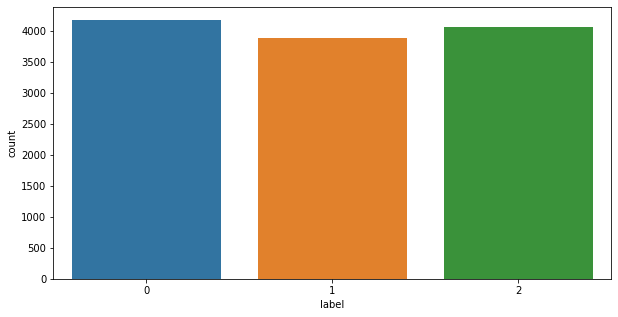

In [ ]:
# Plot a histogram distribution of labels
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=df, order=list(df['label'].value_counts().sort_index().index))

##Dataset 2

This dataset is split in three files.  
'snli_1.0_train.csv' contains train set
'snli_1.0_dev.csv' contains validation set
'snli_1.0_test.csv' contains test set

All the sets above contain premise-hypothesis pairs along with their corresponding labels {0: Entailment, 1: Neutral, 2: Contradiction}

In [ ]:
df = pd.read_csv(DATA_DIR_2 + "snli_1.0_train.csv", sep=",")

The distribution for each label in the dataset 2 can be seen in the histogram below. All three labeled are roughly equaly distributed with about 17500 labeled sentence pairs.

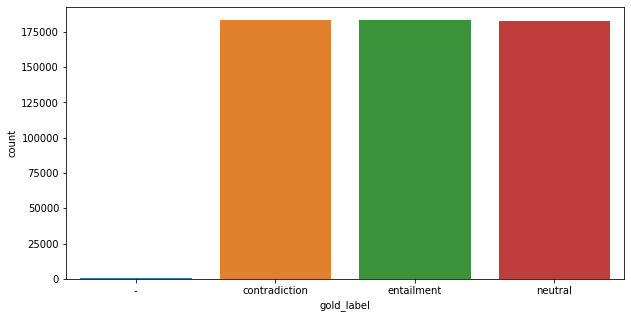

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='gold_label', data=df, order=list(df['gold_label'].value_counts().sort_index().index))

In [ ]:
df

gold_label  ... label5
0             neutral  ...    NaN
1       contradiction  ...    NaN
2          entailment  ...    NaN
3             neutral  ...    NaN
4          entailment  ...    NaN
...               ...  ...    ...
550147  contradiction  ...    NaN
550148        neutral  ...    NaN
550149        neutral  ...    NaN
550150  contradiction  ...    NaN
550151     entailment  ...    NaN

[550152 rows x 14 columns]

#Preprocessing

##Dataset 1

In [ ]:
# Read train and test data
df_train = pd.read_csv(DATA_DIR_1 + "train.csv")
df_test = pd.read_csv(DATA_DIR_1 + "test.csv")

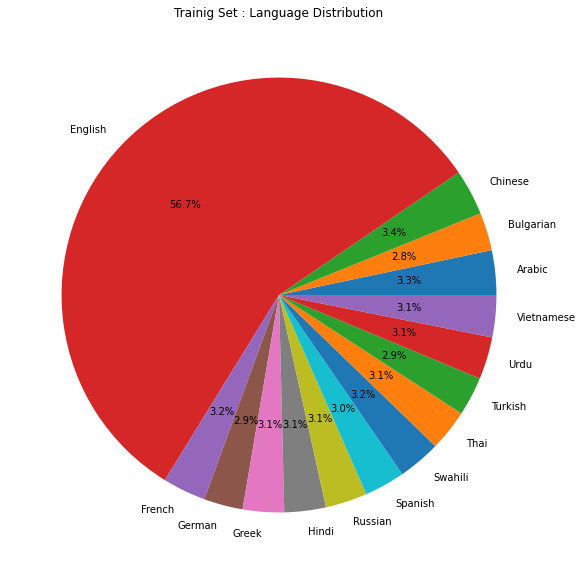

In [ ]:
# Print distribution of languages in a pie chart for visualization

labels, frequencies = np.unique(df_train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.title('Trainig Set : Language Distribution')
plt.show()

Since a large majority of the dataset is in english; We try to convert other premise-hypothesis language pairs to english as well for simplicity and to  cross checking for correctness easier.

In [ ]:
!pip install google_trans_new

In [ ]:
# List all languages google translate API supports
import google_trans_new
print(google_trans_new.LANGUAGES)

{'af': 'afrikaans', 'sq': 'albanian', 'am': 'amharic', 'ar': 'arabic', 'hy': 'armenian', 'az': 'azerbaijani', 'eu': 'basque', 'be': 'belarusian', 'bn': 'bengali', 'bs': 'bosnian', 'bg': 'bulgarian', 'ca': 'catalan', 'ceb': 'cebuano', 'ny': 'chichewa', 'zh-cn': 'chinese (simplified)', 'zh-tw': 'chinese (traditional)', 'co': 'corsican', 'hr': 'croatian', 'cs': 'czech', 'da': 'danish', 'nl': 'dutch', 'en': 'english', 'eo': 'esperanto', 'et': 'estonian', 'tl': 'filipino', 'fi': 'finnish', 'fr': 'french', 'fy': 'frisian', 'gl': 'galician', 'ka': 'georgian', 'de': 'german', 'el': 'greek', 'gu': 'gujarati', 'ht': 'haitian creole', 'ha': 'hausa', 'haw': 'hawaiian', 'iw': 'hebrew', 'he': 'hebrew', 'hi': 'hindi', 'hmn': 'hmong', 'hu': 'hungarian', 'is': 'icelandic', 'ig': 'igbo', 'id': 'indonesian', 'ga': 'irish', 'it': 'italian', 'ja': 'japanese', 'jw': 'javanese', 'kn': 'kannada', 'kk': 'kazakh', 'km': 'khmer', 'ko': 'korean', 'ku': 'kurdish (kurmanji)', 'ky': 'kyrgyz', 'lo': 'lao', 'la': 'lat

In [ ]:
# List all languages in out dataset
labels, frequencies = np.unique(df_train.language.values, return_counts = True)
print(labels,frequencies)

['Arabic' 'Bulgarian' 'Chinese' 'English' 'French' 'German' 'Greek'
 'Hindi' 'Russian' 'Spanish' 'Swahili' 'Thai' 'Turkish' 'Urdu'
 'Vietnamese'] [ 401  342  411 6870  390  351  372  374  376  366  385  371  351  381
  379]


In [ ]:
i = 0 
for x in google_trans_new.LANGUAGES:
    if (x in data_lang):
        i += 1
        print(x,i)
        

ar 1
bg 2
en 3
fr 4
de 5
el 6
hi 7
ru 8
es 9
sw 10
th 11
tr 12
ur 13
vi 14


Since we know there are 15 languages in the dataset. The only language that is missing is with abrevation 'zh', this probably is because it stands for Chinese and its not mentioned whether it is simplified or traditional. So replaced it with 'zh-cn', as both simplified and trandition seem to return the exact same translations (this can be seen in some of the later cells).

In [ ]:
df_train_zh = df_train

In [ ]:
df_train_zh

id  ... label
0      5130fd2cb5  ...     0
1      5b72532a0b  ...     2
2      3931fbe82a  ...     0
3      5622f0c60b  ...     0
4      86aaa48b45  ...     1
...           ...  ...   ...
12115  2b78e2a914  ...     2
12116  7e9943d152  ...     0
12117  5085923e6c  ...     2
12118  fc8e2fd1fe  ...     2
12119  44301dfb14  ...     0

[12120 rows x 6 columns]

In [ ]:
df_train_zh['lang_abv'] = df_train_zh['lang_abv'].replace("zh","zh-cn")

In [ ]:
data_lang 

array(['en', 'fr', 'th', 'tr', 'ur', 'ru', 'bg', 'de', 'ar', 'zh', 'hi',
       'sw', 'vi', 'es', 'el'], dtype=object)

In [ ]:
df_train_zh.lang_abv.unique()

array(['en', 'fr', 'th', 'tr', 'ur', 'ru', 'bg', 'de', 'ar', 'zh-cn',
       'hi', 'sw', 'vi', 'es', 'el'], dtype=object)

In [ ]:
# Functions to cleanup special characters

def remove_space(text):
    return " ".join(text.split())

def remove_punctuation(text):
    return re.sub("[!@#$+%*:()'-]", ' ', text)

def remove_html(text):
    soup = BeautifulSoup(text, 'lxml')
    return soup.get_text()

def remove_url(text):
    return re.sub(r"http\S+", "", text)

def translate(text):
    translator = Translator()
    return translator.translate(text, dest='en').text

def clean_text(text):
    text = remove_space(text)
    text = remove_html(text)
    text = remove_url(text)
    text = remove_punctuation(text)
    return text

Removing special characters from the sentence pairs.

In [ ]:
df_train['premise'] = df_train.premise.progress_apply(lambda text : clean_text(text))

100%|██████████████████████████████| 12120/12120 [00:02<00:00, 4409.34it/s]


In [ ]:
df_train['hypothesis'] = df_train.hypothesis.progress_apply(lambda text : clean_text(text))

100%|██████████████████████████████| 12120/12120 [00:02<00:00, 4436.29it/s]


In [ ]:
df_test['premise'] = df_test.premise.progress_apply(lambda text : clean_text(text))

100%|████████████████████████████████| 5195/5195 [00:01<00:00, 4784.91it/s]


In [ ]:
df_test['hypothesis'] = df_test.hypothesis.progress_apply(lambda text : clean_text(text))

100%|████████████████████████████████| 5195/5195 [00:01<00:00, 4798.91it/s]


Thesting for differences in translation between both traditional and simplified chinese.

In [ ]:
# Print all chinese sentence pairsin the train set
for i in range(len(df_train)):
    if df_train["lang_abv"][i] == "zh":
        print(df_train["premise"][i])

我希望你的领主能够最终开始认识到，向这样的人授予国王委员会的愚蠢行为反对我的所有建议。
争端，管理现在都指向做的这些食物券，当然也可以转向基本福利 —— TANF。
电视晚餐带来了糟糕的污点。
哦我明白这里的气氛了
嗯，我的祖父母总是非常非常的有爱心，而我的父母也是，我们在下边享受美好时光。
迪拜是一个可以轻松到达主要机场，旅行社，酒店和西方商业机构的现代化城市，是一个理想的中转站。
当然，假定法律中存有量子不确定性是相当激进的想法，但这似乎不是不可能。
但是，他们住在奥古斯塔郊外的一个叫伊万斯的小镇上，伊万斯现在还在，我的许多亲戚仍然住在那里。
每天近10万人来到这里欣赏令人眩目的建筑和探索这个不断变化的城市的最新景点。
我的梦想是看到每一个美国人都成为奥运家庭的一员，所以请尽一切可能。
The Friends 在两个层面上运营 - 全市通和各分部 - 并且您可以在一个或两个层面上都激活身份。
我不会怀疑。 他的领主的语气没有减弱其粗野的性格。
IMA的发展委员会将匹配1998年12月31日之前收到的所有认捐，一美元是一美元。
它来自一个飞越古巴的空军基地，当然鲁道夫·安德森被击落了。
涉嫌犯罪的人拥有这些权利。
她的第二个是一个来自垃圾堆上的小狗，这个小公狗有牙齿问题。
19 如果在合同授予前有四个月的时间工作，那么飞瞬即逝的13个月将对改造这个675 MWe锅炉至关重要。
Feisty就像fizzle一样，开始于中古英语的fysten，比如fisten `to fart。
不管怎么说，这个人进来了。
但我想，忘记它，我要去吃午饭，我饿了。
哦，不，但是他们在Oaklawn跑道上进行赛马比赛。
关心国家新闻如何影响地方
如果我们保持低价格，我们需要找到你们，我们的观众，要求我们做出一些小的贡献，以帮助我们完成这项任务。
关于阿塔去捷克共和国的旅行消息，如前所述。
参加我们节目的孩子们通过课堂课程提前准备戏剧经历
回到镇上, 一次海滨漫步会带你穿过繁华街道上的唐人街。
呃，我有点喜欢黑眼豆豆，但是我觉得这并不是一个束缚。
Hazmi的室友记得他在这段时间不知道为什么去了圣地亚哥机场。
好的，你能听到我说话吗?
是的，是的，你知道，如果他们有一个um公司提供资金，我不会如此介意。
我很荣幸接受你的邀请去参加共和党的在全国代表大会上小圈子派对，在八月16到20号，休斯

In [ ]:
df_train.to_csv(DATA_DIR_1 + "ds1_processed.csv")

In [ ]:
# Default translation for 'zh'

translator = google_translator()
text = translator.translate("过去一百年左右出现的语言现象之一是接受这样一个概念：解决问题的一个重要步骤在于给它们命名。",lang_src="zh",lang_tgt="en")

In [ ]:
print(text)

One of the language phenomena that have emerged in the past 100 years or so is the acceptance of the concept that an important step in solving problems is to name them. 


In [ ]:
# Default translation for 'zh-cn'

translator = google_translator()
text = translator.translate("过去一百年左右出现的语言现象之一是接受这样一个概念：解决问题的一个重要步骤在于给它们命名。",lang_src="zh-cn",lang_tgt="en")
print(text)

One of the language phenomena that have emerged in the past 100 years or so is the acceptance of the concept that an important step in solving problems is to name them. 


In [ ]:
# Default translation for 'zh-tw'

translator = google_translator()
text = translator.translate("过去一百年左右出现的语言现象之一是接受这样一个概念：解决问题的一个重要步骤在于给它们命名。",lang_src="zh-tw",lang_tgt="en")
print(text)

One of the language phenomena that have emerged in the past 100 years or so is the acceptance of the concept that an important step in solving problems is to name them. 


In [ ]:
df_tt =df_train

In [ ]:
df_tt

id  ... label
0      5130fd2cb5  ...     0
1      5b72532a0b  ...     2
2      3931fbe82a  ...     0
3      5622f0c60b  ...     0
4      86aaa48b45  ...     1
...           ...  ...   ...
12115  2b78e2a914  ...     2
12116  7e9943d152  ...     0
12117  5085923e6c  ...     2
12118  fc8e2fd1fe  ...     2
12119  44301dfb14  ...     0

[12120 rows x 6 columns]

In [ ]:
df_tt["hypothesis"][0]  = "Hi"

To remove rows that cannot be translated properly make a list of premise-hypothesis pairs that failed to translate while trying to translate each sentence pair.

In [ ]:
from google_trans_new import  google_translator
translator = google_translator()  
en_premise =[]
to_remove_premise = []
for i in range (len(df_train)):
    #print(df_train["premise"][i],df_train["lang_abv"][i])
    text = df_train["premise"][i]
    src = df_train["lang_abv"][i]
    #print(str(text),str(src))
    if (str(src)!="en"):
        try:
            translate_text = translator.translate(str(text),lang_src=str(src),lang_tgt="en")
        #print(translate_text)
            en_premise.append(translate_text)
            df_train["premise"][i] = translate_text
        except:
            print(src,i," ",text)
            to_remove_premise.append(i)
    else:
        en_premise.append(text)

In [ ]:
to_remove_premise

[]

In [ ]:
en_premise

['and these comments were considered in formulating the interim rules.',
 'These are issues that we wrestle with in practice groups of law firms, she said.',
 'Little things like these make a huge difference in what I try to do. ',
 'you know they can t really defend themselves like somebody grown uh say my age you know yeah',
 'In role playing as well Opportunities to express and play multiple roles simultaneously may help children capture similarities and differences between people in their desires, beliefs, and feelings. ',
 'You might hear someone on a farm saying we should cut these oxen in the net, which probably means, separate the ones to load. ',
 'On his return to the United States, Hajj met at the airport through FBI agents, investigated, and met with Osama bin Laden before the Federal Green Jury the next day. ',
 'From Cockpit Country to St. Ann s Bay',
 'Look, it s your skin, but you re going to be in trouble if you don t get busy.',
 'Every hundred degrees, paint spots ch

In [ ]:
from google_trans_new import  google_translator
translator = google_translator()  
en_premise_test =[]
to_remove_premise_test = []
for i in range (len(df_test)):
    #print(df_train["premise"][i],df_train["lang_abv"][i])
    text = df_test["premise"][i]
    src = df_test["lang_abv"][i]
    #print(str(text),str(src))
    if (str(src)!="en"):
        try:
            translate_text = translator.translate(str(text),lang_src=str(src),lang_tgt="en")
        #print(translate_text)
            en_premise_test.append(translate_text)
            df_test["premise"][i] = translate_text
        except:
            print(src,i," ",text)
            to_remove_premise_test.append(i)
    else:
        en_premise_test.append(text)

In [ ]:
to_remove_premise_test

[]

In [ ]:
en_premise_test

['The boxes will be named after Box, Casey, Rachel, Isaiah, Kelly, Kelly, and other Columbine High School students who lost their lives earlier this year. ',
 'This is what we were advised to do. ',
 'and this is largely due to the fact that mothers take drugs ',
 'Dialogue &amp with representatives of cities and other citizens and community organizations on the artistic development of IMA ',
 'She was still there. ',
 'His family had lost a son and a daughter now.',
 'Steps are initiated to allow program board membership to reflect the clienteligible community and include representatives from the funding community, corporations and other partners.',
 'It was probably the first thing I remembered from my early childhood, and especially about being silly. ',
 'agencies  operating trust, enterprise and internal service funds  are required to produce auditable financial statements.',
 'No one knew where they went. ',
 'how long has he been in his present position',
 'It usually takes long

In [ ]:
df_test

id  ... language
0     c6d58c3f69  ...     Urdu
1     cefcc82292  ...   Arabic
2     e98005252c  ...   French
3     58518c10ba  ...  Chinese
4     c32b0d16df  ...  Russian
...          ...  ...      ...
5190  5f90dd59b0  ...     Urdu
5191  f357a04e86  ...  English
5192  1f0ea92118  ...  Chinese
5193  0407b48afb  ...  English
5194  16c2f2ab89  ...  English

[5195 rows x 5 columns]

In [ ]:
from google_trans_new import  google_translator
translator = google_translator()  
en_hypothesis_test =[]
to_remove_hypothesis_test = []
for i in range (len(df_test)):
    #print(df_train["premise"][i],df_train["lang_abv"][i])
    text = df_test["hypothesis"][i]
    src = df_test["lang_abv"][i]
    #print(str(text),str(src))
    if (str(src)!="en"):
        try:
            translate_text = translator.translate(str(text),lang_src=str(src),lang_tgt="en")
        #print(translate_text)
            en_hypothesis_test.append(translate_text)
            df_test["hypothesis"][i] = translate_text
        except:
            print(src,i," ",text)
            to_remove_hypothesis_test.append(i)

    else:
        en_hypothesis_test.append(text)

In [ ]:
df_test


id  ... language
0     c6d58c3f69  ...     Urdu
1     cefcc82292  ...   Arabic
2     e98005252c  ...   French
3     58518c10ba  ...  Chinese
4     c32b0d16df  ...  Russian
...          ...  ...      ...
5190  5f90dd59b0  ...     Urdu
5191  f357a04e86  ...  English
5192  1f0ea92118  ...  Chinese
5193  0407b48afb  ...  English
5194  16c2f2ab89  ...  English

[5195 rows x 5 columns]

In [ ]:
df_t = df

In [ ]:
from google_trans_new import  google_translator
translator = google_translator()  
en_hypothesis =[]
to_remove_hypothesis = []
for i in range (len(df_test)):
    #print(df_train["premise"][i],df_train["lang_abv"][i])
    text = df_train["hypothesis"][i]
    src = df_train["lang_abv"][i]
    #print(str(text),str(src))
    if (str(src)!="en"):
        try:
            translate_text = translator.translate(str(text),lang_src=str(src),lang_tgt="en")
        #print(translate_text)
            en_hypothesis.append(translate_text)
            df_train["hypothesis"][i] = translate_text
        except:
            print(src,i," ",text)
            to_remove_hypothesis.append(i)

    else:
        en_hypothesis.append(text)

In [ ]:
to_remove_hypothesis

[]

In [ ]:
df_train.iloc[10000-12]

id                                                   41be7e7d47
premise       The child Sonia moaned while slogging into Mer...
hypothesis    Sonja ร้องโหยหวนอย่างบ้าคลั่งในขณะที่กำลังโบยบ...
lang_abv                                                     th
language                                                   Thai
label                                                         0
Name: 9988, dtype: object

In [ ]:
to_remove_premise

[]

In [ ]:
en_hypothesis

['The rules developed in the interim were put together with these comments in mind.',
 'Practice groups are not permitted to work on these issues.',
 'I was trying to accomplish something. ',
 'They can t defend themselves because of their age.',
 'Children can see how different ethnic groups are. ',
 'People on the farm use different terms. ',
 'The Hague was investigated by FBI agents ',
 'From St. Ann s Bay to Cockpit Country.',
 'The boss will fire you if he sees you slacking off.',
 'The paint changes to match the color. ',
 'We had everything we really needed. ',
 'Could the interest be more than 20? ',
 'If you can, try to understand the plot at first. ',
 'My lord just accepted my opinion and took corresponding action. ',
 'Mazoudi claimed that he went along with the plan as planned. ',
 "Children could go to their neighbors' houses. ",
 'Many people have poisoned someone by mistake.',
 'An example is policy wonking.',
 'The system is corrupt because he won t be able to get par

In [ ]:
df_test

In [ ]:
b =[]
for x in to_remove_premise_test:
    b.append(int(x))

for x in to_remove_hypothesis_test:
    b.append(int(x))

In [ ]:
df_check_test = df_test.drop(b,axis=0)

In [ ]:
to_remove_hypothesis b

[8822, 11078]

In [ ]:
for x in to_remove_hypothesis:
    print(type(x))

<class 'int'>
<class 'int'>


In [ ]:
type(to_remove_hypothesis)

list

In [ ]:
a = []
for x in to_remove_hypothesis:
    a.append(int(x))

In [ ]:
for x in to_remove_premise:
    a.append(int(x))

In [ ]:
a

[]

In [ ]:
df_train.drop(a,axis=0)

id  ... label
0      5130fd2cb5  ...     0
1      5b72532a0b  ...     2
2      3931fbe82a  ...     0
3      5622f0c60b  ...     0
4      86aaa48b45  ...     1
...           ...  ...   ...
12115  2b78e2a914  ...     2
12116  7e9943d152  ...     0
12117  5085923e6c  ...     2
12118  fc8e2fd1fe  ...     2
12119  44301dfb14  ...     0

[12120 rows x 6 columns]

In [ ]:
len(df_train)

12120

In [ ]:
df_check = df_train.drop(a,axis=0)

In [ ]:
len(df_check)

12114

In [ ]:
df_check

id  ... label
0      5130fd2cb5  ...     0
1      5b72532a0b  ...     2
2      3931fbe82a  ...     0
3      5622f0c60b  ...     0
4      86aaa48b45  ...     1
...           ...  ...   ...
12115  2b78e2a914  ...     2
12116  7e9943d152  ...     0
12117  5085923e6c  ...     2
12118  fc8e2fd1fe  ...     2
12119  44301dfb14  ...     0

[12120 rows x 6 columns]

In [ ]:
df = df_check[["premise","hypothesis","label"]]

In [ ]:
df.to_csv(DATA_DIR_1 + "translated_text.csv")

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/Data/stanford-natural-language-inference-corpus/train_data2.csv")

In [ ]:
df1

premise  ... label
0       A person on a horse jumps over a broken down a...  ...     1
1       A person on a horse jumps over a broken down a...  ...     2
2       A person on a horse jumps over a broken down a...  ...     0
3                   Children smiling and waving at camera  ...     1
4                   Children smiling and waving at camera  ...     0
...                                                   ...  ...   ...
549356                Four dirty and barefooted children.  ...     2
549357                Four dirty and barefooted children.  ...     1
549358  A man is surfing in a bodysuit in beautiful bl...  ...     1
549359  A man is surfing in a bodysuit in beautiful bl...  ...     2
549360  A man is surfing in a bodysuit in beautiful bl...  ...     0

[549361 rows x 3 columns]

In [ ]:
frames = [df,df1]
df2 = pd.concat(frames)

In [ ]:
df.iloc[10000-12]

premise       The child Sonia moaned while slogging into Mer...
hypothesis    Sonja ร้องโหยหวนอย่างบ้าคลั่งในขณะที่กำลังโบยบ...
label                                                         0
Name: 9988, dtype: object

In [ ]:
df2

premise  ... label
0       and these comments were considered in formulat...  ...     0
1       These are issues that we wrestle with in pract...  ...     2
2       Little things like these make a huge differenc...  ...     0
3       you know they can t really defend themselves l...  ...     0
4       In role playing as well Opportunities to expre...  ...     1
...                                                   ...  ...   ...
549356                Four dirty and barefooted children.  ...     2
549357                Four dirty and barefooted children.  ...     1
549358  A man is surfing in a bodysuit in beautiful bl...  ...     1
549359  A man is surfing in a bodysuit in beautiful bl...  ...     2
549360  A man is surfing in a bodysuit in beautiful bl...  ...     0

[561481 rows x 3 columns]

In [ ]:
df2.iloc[10000-12]

premise       The child Sonia moaned while slogging into Mer...
hypothesis    Sonja ร้องโหยหวนอย่างบ้าคลั่งในขณะที่กำลังโบยบ...
label                                                         0
Name: 9988, dtype: object

In [ ]:
import csv

with open(DATA_DIR_1 + "translated_train.csv","w") as f:
    csvwriter =csv.writer(f)
    csvwriter.writerows(df_check.values)

In [ ]:
import csv

with open(DATA_DIR_1 + "translated_test.csv","w") as f:
    csvwriter =csv.writer(f)
    csvwriter.writerows(df_check_test.values)

In [ ]:
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/Data/contradictory-my-dear-watson/translated_train.csv")
test = pd.read_csv("/content/drive/MyDrive/Data/contradictory-my-dear-watson/translated_test.csv")

In [ ]:
train 

5130fd2cb5  ...  0
0      5b72532a0b  ...  2
1      3931fbe82a  ...  0
2      5622f0c60b  ...  0
3      86aaa48b45  ...  1
4      ed7d6a1e62  ...  0
...           ...  ... ..
12114  2b78e2a914  ...  2
12115  7e9943d152  ...  0
12116  5085923e6c  ...  2
12117  fc8e2fd1fe  ...  2
12118  44301dfb14  ...  0

[12119 rows x 6 columns]

In [ ]:
test 

c6d58c3f69  ...     Urdu
0     cefcc82292  ...   Arabic
1     e98005252c  ...   French
2     58518c10ba  ...  Chinese
3     c32b0d16df  ...  Russian
4     aa2510d454  ...  English
...          ...  ...      ...
5189  5f90dd59b0  ...     Urdu
5190  f357a04e86  ...  English
5191  1f0ea92118  ...  Chinese
5192  0407b48afb  ...  English
5193  16c2f2ab89  ...  English

[5194 rows x 5 columns]

In [ ]:
df_check_test.head(1) 

id  ... language
0  c6d58c3f69  ...     Urdu

[1 rows x 5 columns]

In [ ]:


def read_data(filename):

    df = pd.read_csv(filename,names=['id','premise','hypothesis','lang_abv','languagae'])
    return df

In [ ]:
import pandas as pd
train = read_data("/content/drive/MyDrive/Data/contradictory-my-dear-watson/translated_train.csv")
test = read_data("/content/drive/MyDrive/Data/contradictory-my-dear-watson/translated_test.csv")

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Data/contradictory-my-dear-watson/translated_train.csv")

In [ ]:
train 

5130fd2cb5  ...  0
0      5b72532a0b  ...  2
1      3931fbe82a  ...  0
2      5622f0c60b  ...  0
3      86aaa48b45  ...  1
4      ed7d6a1e62  ...  0
...           ...  ... ..
12114  2b78e2a914  ...  2
12115  7e9943d152  ...  0
12116  5085923e6c  ...  2
12117  fc8e2fd1fe  ...  2
12118  44301dfb14  ...  0

[12119 rows x 6 columns]

In [ ]:
train.columns = ["id","premise","hypothesis","lang_abv","language","labels"]

In [ ]:
train.head()

id  ... labels
0  5b72532a0b  ...      2
1  3931fbe82a  ...      0
2  5622f0c60b  ...      0
3  86aaa48b45  ...      1
4  ed7d6a1e62  ...      0

[5 rows x 6 columns]

In [ ]:
train.to_csv('/content/drive/MyDrive/Data/contradictory-my-dear-watson/processed_train.csv')

In [ ]:
test.to_csv('/content/drive/MyDrive/Data/contradictory-my-dear-watson/processed_test.csv')

In [ ]:
test 

id  ... languagae
0     c6d58c3f69  ...      Urdu
1     cefcc82292  ...    Arabic
2     e98005252c  ...    French
3     58518c10ba  ...   Chinese
4     c32b0d16df  ...   Russian
...          ...  ...       ...
5190  5f90dd59b0  ...      Urdu
5191  f357a04e86  ...   English
5192  1f0ea92118  ...   Chinese
5193  0407b48afb  ...   English
5194  16c2f2ab89  ...   English

[5195 rows x 5 columns]

In [ ]:
test["hypothesis"]

0       There will be no memorial to Casey, one of Col...
1       When they are told what to do, management has ...
2                                    Mothers take drugs. 
3       IMA cooperates with other organizations becaus...
4         We thought that she left, however, she stayed. 
                              ...                        
5190      Nemeth is being paid to investigate the motel. 
5191          The rock is harder than most types of rock.
5192    The fact that she was only present after the f...
5193    I could see downtown Dallas from where I lived...
5194    It s impossible to have a plate hand painted t...
Name: hypothesis, Length: 5195, dtype: object

In [ ]:
train["hypothesis"]

0        Practice groups are not permitted to work on t...
1                   I was trying to accomplish something. 
2        They can t defend themselves because of their ...
3        Children can see how different ethnic groups a...
4                 People on the farm use different terms. 
                               ...                        
12114    All studies have the same amount of uncertaint...
12115    But there are two kinds of the pleasure of doi...
12116                     It cannot be moved, now or ever.
12117         The model temple complex is at the east end.
12118        Ataturk was the father of the Turkish nation.
Name: hypothesis, Length: 12119, dtype: object

In [ ]:
trainX = pd.read_csv("/content/drive/MyDrive/Data/contradictory-my-dear-watson/processed_train.csv")

In [ ]:
testX = pd.read_csv("/content/drive/MyDrive/Data/contradictory-my-dear-watson/processed_test.csv")

In [ ]:
trainX

Unnamed: 0          id  ... language labels
0               0  5b72532a0b  ...  English      2
1               1  3931fbe82a  ...   French      0
2               2  5622f0c60b  ...  English      0
3               3  86aaa48b45  ...     Thai      1
4               4  ed7d6a1e62  ...  Turkish      0
...           ...         ...  ...      ...    ...
12114       12114  2b78e2a914  ...  English      2
12115       12115  7e9943d152  ...  English      0
12116       12116  5085923e6c  ...  English      2
12117       12117  fc8e2fd1fe  ...  English      2
12118       12118  44301dfb14  ...  English      0

[12119 rows x 7 columns]

In [ ]:
testX

Unnamed: 0          id  ... lang_abv languagae
0              0  c6d58c3f69  ...       ur      Urdu
1              1  cefcc82292  ...       ar    Arabic
2              2  e98005252c  ...       fr    French
3              3  58518c10ba  ...       zh   Chinese
4              4  c32b0d16df  ...       ru   Russian
...          ...         ...  ...      ...       ...
5190        5190  5f90dd59b0  ...       ur      Urdu
5191        5191  f357a04e86  ...       en   English
5192        5192  1f0ea92118  ...       zh   Chinese
5193        5193  0407b48afb  ...       en   English
5194        5194  16c2f2ab89  ...       en   English

[5195 rows x 6 columns]

In [ ]:
trainX.columns

Index(['Unnamed: 0', 'id', 'premise', 'hypothesis', 'lang_abv', 'language',
       'labels'],
      dtype='object')

In [ ]:
testX.columns

Index(['Unnamed: 0', 'id', 'premise', 'hypothesis', 'lang_abv', 'languagae'], dtype='object')

In [ ]:
trainX = trainX.drop("Unnamed: 0", axis=1 )

In [ ]:
trainX

id  ... labels
0      5b72532a0b  ...      2
1      3931fbe82a  ...      0
2      5622f0c60b  ...      0
3      86aaa48b45  ...      1
4      ed7d6a1e62  ...      0
...           ...  ...    ...
12114  2b78e2a914  ...      2
12115  7e9943d152  ...      0
12116  5085923e6c  ...      2
12117  fc8e2fd1fe  ...      2
12118  44301dfb14  ...      0

[12119 rows x 6 columns]

In [ ]:
testX = testX.drop('Unnamed: 0',axis=1)

In [ ]:
testX

id  ... languagae
0     c6d58c3f69  ...      Urdu
1     cefcc82292  ...    Arabic
2     e98005252c  ...    French
3     58518c10ba  ...   Chinese
4     c32b0d16df  ...   Russian
...          ...  ...       ...
5190  5f90dd59b0  ...      Urdu
5191  f357a04e86  ...   English
5192  1f0ea92118  ...   Chinese
5193  0407b48afb  ...   English
5194  16c2f2ab89  ...   English

[5195 rows x 5 columns]

In [ ]:
trainX.columns

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'labels'], dtype='object')

In [ ]:
testX.columns

Index(['id', 'premise', 'hypothesis', 'lang_abv', 'languagae'], dtype='object')

##Dataset 2

In [ ]:
df_train = pd.read_csv(DATA_DIR_2 + "snli_1.0_train.csv")
df_test = pd.read_csv(DATA_DIR_2 + "snli_1.0_test.csv")
df_dev = pd.read_csv(DATA_DIR_2 + "snli_1.0_dev.csv")

In [ ]:
del df_train['sentence1_binary_parse']
del df_train['sentence2_binary_parse']
del df_train['sentence1_parse']
del df_train['sentence2_parse']
del df_train['captionID']
del df_train['pairID']
del df_train['label1']
del df_train['label2']
del df_train['label3']
del df_train['label4']
del df_train['label5']

In [ ]:
df_train

gold_label  ...                                          sentence2
0             neutral  ...  A person is training his horse for a competition.
1       contradiction  ...      A person is at a diner, ordering an omelette.
2          entailment  ...                  A person is outdoors, on a horse.
3             neutral  ...                  They are smiling at their parents
4          entailment  ...                         There are children present
...               ...  ...                                                ...
550147  contradiction  ...           four kids won awards for 'cleanest feet'
550148        neutral  ...  four homeless children had their shoes stolen,...
550149        neutral  ...  A man in a bodysuit is competing in a surfing ...
550150  contradiction  ...  A man in a business suit is heading to a board...
550151     entailment  ...  On the beautiful blue water there is a man in ...

[550152 rows x 3 columns]

In [ ]:
def remove_space(text):
    return " ".join(text.split())

def remove_punctuation(text):
    return re.sub("[!@#$+%*:()'-]", ' ', text)

def remove_html(text):
    soup = BeautifulSoup(text, 'lxml')
    return soup.get_text()

def remove_url(text):
    return re.sub(r"http\S+", "", text)

def translate(text):
    translator = Translator()
    return translator.translate(text, dest='en').text

def clean_text(text):
    text = remove_space(text)
    text = remove_html(text)
    text = remove_url(text)
    text = remove_punctuation(text)
    return text

In [ ]:
#training data preprocessing
df_train = df_train.reindex(columns= ['sentence1', 'sentence2', 'gold_label'])
df_train.columns = ['premise','hypothesis','label']
print(df_train['label'].value_counts())
df_train = df_train[df_train.label != '-']

#remove missing values
df_train = df_train.dropna()

#encode labels
numeric_labels = {"entailment": 0, "neutral": 1, "contradiction": 2}
df_train['label'] = df_train.label.map(numeric_labels)

entailment       183416
contradiction    183187
neutral          182764
-                   785
Name: label, dtype: int64


In [ ]:
df_train["premise"] = df_train.premise.progress_apply(lambda text : clean_text(text))
df_train["hypothesis"] = df_train.hypothesis.progress_apply(lambda text : clean_text(text))

100%|████████████████████████████| 549361/549361 [02:08<00:00, 4265.10it/s]


In [ ]:
df_train

premise  ... label
0       A person on a horse jumps over a broken down a...  ...     1
1       A person on a horse jumps over a broken down a...  ...     2
2       A person on a horse jumps over a broken down a...  ...     0
3                   Children smiling and waving at camera  ...     1
4                   Children smiling and waving at camera  ...     0
...                                                   ...  ...   ...
550147                Four dirty and barefooted children.  ...     2
550148                Four dirty and barefooted children.  ...     1
550149  A man is surfing in a bodysuit in beautiful bl...  ...     1
550150  A man is surfing in a bodysuit in beautiful bl...  ...     2
550151  A man is surfing in a bodysuit in beautiful bl...  ...     0

[549361 rows x 3 columns]

In [ ]:
del df_test['sentence1_binary_parse']
del df_test['sentence2_binary_parse']
del df_test['sentence1_parse']
del df_test['sentence2_parse']
del df_test['captionID']
del df_test['pairID']
del df_test['label1']
del df_test['label2']
del df_test['label3']
del df_test['label4']
del df_test['label5']

In [ ]:
#testing data preprocessing

df_test=df_test.reindex(columns= ['sentence1', 'sentence2', 'gold_label'])
df_test.columns = ['premise','hypothesis', 'label']
print(df_test['label'].value_counts())
df_test = df_test[df_test.label != '-']

#remove missing values
df_test = df_test.dropna()

#encode labels
numeric_labels = {"entailment": 0, "neutral": 1, "contradiction": 2}
df_test['label'] = df_test.label.map(numeric_labels)

entailment       3368
contradiction    3237
neutral          3219
-                 176
Name: label, dtype: int64


In [ ]:
df_test["premise"] = df_test.premise.progress_apply(lambda text : clean_text(text))
df_test["hypothesis"] = df_test.hypothesis.progress_apply(lambda text : clean_text(text))

100%|████████████████████████████████| 9824/9824 [00:02<00:00, 4006.80it/s]


In [ ]:
#export as csv
df_train.to_csv(DATA_DIR_2 + "train_data2.csv", index=False)

df_test.to_csv(DATA_DIR_2 + "test_data2.csv", index=False)

df_dev.to_csv(DATA_DIR_2 + "Dev_data2.csv", index=False)

In [ ]:
import pandas as pd
train_data2 = pd.read_csv(DATA_DIR_2 + "train_data2.csv")
test_data2 = pd.read_csv(DATA_DIR_2 + "test_data2.csv")
dev_data2 = pd.read_csv(DATA_DIR_2 + "Dev_data2.csv")

In [ ]:
train_data2

premise  ... label
0       A person on a horse jumps over a broken down a...  ...     1
1       A person on a horse jumps over a broken down a...  ...     2
2       A person on a horse jumps over a broken down a...  ...     0
3                   Children smiling and waving at camera  ...     1
4                   Children smiling and waving at camera  ...     0
...                                                   ...  ...   ...
549356                Four dirty and barefooted children.  ...     2
549357                Four dirty and barefooted children.  ...     1
549358  A man is surfing in a bodysuit in beautiful bl...  ...     1
549359  A man is surfing in a bodysuit in beautiful bl...  ...     2
549360  A man is surfing in a bodysuit in beautiful bl...  ...     0

[549361 rows x 3 columns]

In [ ]:
test_data2

premise  ... label
0     This church choir sings to the masses as they ...  ...     1
1     This church choir sings to the masses as they ...  ...     0
2     This church choir sings to the masses as they ...  ...     2
3     A woman with a green headscarf, blue shirt and...  ...     1
4     A woman with a green headscarf, blue shirt and...  ...     0
...                                                 ...  ...   ...
9819        Two women are observing something together.  ...     2
9820        Two women are observing something together.  ...     0
9821  A man in a black leather jacket and a book in ...  ...     2
9822  A man in a black leather jacket and a book in ...  ...     0
9823  A man in a black leather jacket and a book in ...  ...     1

[9824 rows x 3 columns]

In [ ]:
print("Train:",train_data2.shape)
print("Test:",test_data2.shape)
print("Dev:",dev_data2.shape)

Train: (549361, 3)
Test: (9824, 3)
Dev: (9842, 3)


## Combining The Datasets : Dataset

In [ ]:
def read_data(filename):

    df = pd.read_csv(filename,names=['id','premise','hypothesis','lang_abv','languagae'],header=None)
    return df

In [ ]:
trainX = pd.read_csv(DATA_DIR_1 + "translated_train.csv")
#testX = pd.read_csv(DATA_DIR_1 + "processed_test.csv")

In [ ]:
trainX.columns

Index(['5130fd2cb5',
       'and these comments were considered in formulating the interim rules.',
       'The rules developed in the interim were put together with these comments in mind.',
       'en', 'English', '0'],
      dtype='object')

In [ ]:
trainX.columns = ["id","premise","hypothesis","lang_abv","language","label"]

In [ ]:
trainX

id  ... label
0      5b72532a0b  ...     2
1      3931fbe82a  ...     0
2      5622f0c60b  ...     0
3      86aaa48b45  ...     1
4      ed7d6a1e62  ...     0
...           ...  ...   ...
12114  2b78e2a914  ...     2
12115  7e9943d152  ...     0
12116  5085923e6c  ...     2
12117  fc8e2fd1fe  ...     2
12118  44301dfb14  ...     0

[12119 rows x 6 columns]

In [ ]:
trainX.lang_abv

5130fd2cb5    English
5b72532a0b    English
3931fbe82a     French
5622f0c60b    English
86aaa48b45       Thai
               ...   
2b78e2a914    English
7e9943d152    English
5085923e6c    English
fc8e2fd1fe    English
44301dfb14    English
Name: lang_abv, Length: 12120, dtype: object

In [ ]:

train_data2 = pd.read_csv(DATA_DIR_2 + "train_data2.csv")
#test_data2 = pd.read_csv(DATA_DIR_2 + "test_data2.csv")
#dev_data2 = pd.read_csv(DATA_DIR_2 + "Dev_data2.csv")


In [ ]:
train_data2

premise  ... label
0       A person on a horse jumps over a broken down a...  ...     1
1       A person on a horse jumps over a broken down a...  ...     2
2       A person on a horse jumps over a broken down a...  ...     0
3                   Children smiling and waving at camera  ...     1
4                   Children smiling and waving at camera  ...     0
...                                                   ...  ...   ...
549356                Four dirty and barefooted children.  ...     2
549357                Four dirty and barefooted children.  ...     1
549358  A man is surfing in a bodysuit in beautiful bl...  ...     1
549359  A man is surfing in a bodysuit in beautiful bl...  ...     2
549360  A man is surfing in a bodysuit in beautiful bl...  ...     0

[549361 rows x 3 columns]

In [ ]:
frames = [trainX,train_data2]
df = pd.concat(frames)

In [ ]:
len(trainX)

12119

In [ ]:
len(train_data2)

549361

In [ ]:
len(df)

561480

In [ ]:
trainX

Unnamed: 0          id  ... language labels
0               0  5b72532a0b  ...  English      2
1               1  3931fbe82a  ...   French      0
2               2  5622f0c60b  ...  English      0
3               3  86aaa48b45  ...     Thai      1
4               4  ed7d6a1e62  ...  Turkish      0
...           ...         ...  ...      ...    ...
12114       12114  2b78e2a914  ...  English      2
12115       12115  7e9943d152  ...  English      0
12116       12116  5085923e6c  ...  English      2
12117       12117  fc8e2fd1fe  ...  English      2
12118       12118  44301dfb14  ...  English      0

[12119 rows x 7 columns]

In [ ]:
trainX = trainX.reindex(columns= ['premise', 'hypothesis', 'labels'])

In [ ]:
testX

Unnamed: 0          id  ... lang_abv languagae
0              0  c6d58c3f69  ...       ur      Urdu
1              1  cefcc82292  ...       ar    Arabic
2              2  e98005252c  ...       fr    French
3              3  58518c10ba  ...       zh   Chinese
4              4  c32b0d16df  ...       ru   Russian
...          ...         ...  ...      ...       ...
5190        5190  5f90dd59b0  ...       ur      Urdu
5191        5191  f357a04e86  ...       en   English
5192        5192  1f0ea92118  ...       zh   Chinese
5193        5193  0407b48afb  ...       en   English
5194        5194  16c2f2ab89  ...       en   English

[5195 rows x 6 columns]

In [ ]:
testX = testX.reindex(columns= ['premise', 'hypothesis', 'labels'])

In [ ]:
testX

premise  ... labels
0     The boxes will be named after Box, Casey, Rach...  ...    NaN
1                  This is what we were advised to do.   ...    NaN
2     and this is largely due to the fact that mothe...  ...    NaN
3     Dialogue &amp with representatives of cities a...  ...    NaN
4                                 She was still there.   ...    NaN
...                                                 ...  ...    ...
5190  Sleep promised that Motel did the research in ...  ...    NaN
5191  The rock has a soft texture and can be bought ...  ...    NaN
5192  Her current existence, and considering the nat...  ...    NaN
5193  isn t it i can remember i ve only been here ei...  ...    NaN
5194  In Hong Kong you can have a plate, or even a w...  ...    NaN

[5195 rows x 3 columns]

In [ ]:
test_data2

premise  ... label
0     This church choir sings to the masses as they ...  ...     1
1     This church choir sings to the masses as they ...  ...     0
2     This church choir sings to the masses as they ...  ...     2
3     A woman with a green headscarf, blue shirt and...  ...     1
4     A woman with a green headscarf, blue shirt and...  ...     0
...                                                 ...  ...   ...
9819        Two women are observing something together.  ...     2
9820        Two women are observing something together.  ...     0
9821  A man in a black leather jacket and a book in ...  ...     2
9822  A man in a black leather jacket and a book in ...  ...     0
9823  A man in a black leather jacket and a book in ...  ...     1

[9824 rows x 3 columns]

In [ ]:
dev_data2

premise  ... label
0     Two women are embracing while holding to go pa...  ...     1
1     Two women are embracing while holding to go pa...  ...     0
2     Two women are embracing while holding to go pa...  ...     2
3     Two young children in blue jerseys, one with t...  ...     0
4     Two young children in blue jerseys, one with t...  ...     1
...                                                 ...  ...   ...
9837  A small girl wearing a pink jacket is riding o...  ...     0
9838  A small girl wearing a pink jacket is riding o...  ...     2
9839  A young girl with blue and pink ribbons in her...  ...     0
9840  A young girl with blue and pink ribbons in her...  ...     2
9841  A young girl with blue and pink ribbons in her...  ...     1

[9842 rows x 3 columns]

In [ ]:
trainX

premise  ... labels
0      These are issues that we wrestle with in pract...  ...      2
1      Little things like these make a huge differenc...  ...      0
2      you know they can t really defend themselves l...  ...      0
3      In role playing as well Opportunities to expre...  ...      1
4      You might hear someone on a farm saying we sho...  ...      0
...                                                  ...  ...    ...
12114  The results of even the most well designed epi...  ...      2
12115  But there are two kinds of the pleasure of doi...  ...      0
12116  The important thing is to realize that it s wa...  ...      2
12117  At the west end is a detailed model of the who...  ...      2
12118  For himself he chose Atat??rk, or Father of th...  ...      0

[12119 rows x 3 columns]

In [ ]:
train_data2

premise  ... label
0       A person on a horse jumps over a broken down a...  ...     1
1       A person on a horse jumps over a broken down a...  ...     2
2       A person on a horse jumps over a broken down a...  ...     0
3                   Children smiling and waving at camera  ...     1
4                   Children smiling and waving at camera  ...     0
...                                                   ...  ...   ...
549356                Four dirty and barefooted children.  ...     2
549357                Four dirty and barefooted children.  ...     1
549358  A man is surfing in a bodysuit in beautiful bl...  ...     1
549359  A man is surfing in a bodysuit in beautiful bl...  ...     2
549360  A man is surfing in a bodysuit in beautiful bl...  ...     0

[549361 rows x 3 columns]

In [ ]:
df3 = pd.concat([trainX,train_data2])

In [ ]:
df3

premise  ... label
0       These are issues that we wrestle with in pract...  ...   NaN
1       Little things like these make a huge differenc...  ...   NaN
2       you know they can t really defend themselves l...  ...   NaN
3       In role playing as well Opportunities to expre...  ...   NaN
4       You might hear someone on a farm saying we sho...  ...   NaN
...                                                   ...  ...   ...
549356                Four dirty and barefooted children.  ...   2.0
549357                Four dirty and barefooted children.  ...   1.0
549358  A man is surfing in a bodysuit in beautiful bl...  ...   1.0
549359  A man is surfing in a bodysuit in beautiful bl...  ...   2.0
549360  A man is surfing in a bodysuit in beautiful bl...  ...   0.0

[561480 rows x 4 columns]

In [ ]:
df4 = pd.concat([testX,test_data2])

In [ ]:
df4

premise  ... label
0     The boxes will be named after Box, Casey, Rach...  ...   NaN
1                  This is what we were advised to do.   ...   NaN
2     and this is largely due to the fact that mothe...  ...   NaN
3     Dialogue &amp with representatives of cities a...  ...   NaN
4                                 She was still there.   ...   NaN
...                                                 ...  ...   ...
9819        Two women are observing something together.  ...   2.0
9820        Two women are observing something together.  ...   0.0
9821  A man in a black leather jacket and a book in ...  ...   2.0
9822  A man in a black leather jacket and a book in ...  ...   0.0
9823  A man in a black leather jacket and a book in ...  ...   1.0

[15019 rows x 4 columns]

In [ ]:
df.to_csv(DATA_DIR_3 + "final_combined.csv")

In [ ]:
#export as csv
df3.to_csv(DATA_DIR_3 + "train_data_combined.csv", index=False)

df4.to_csv(DATA_DIR_3 + "test_data_combined.csv", index=False)


In [ ]:
#export as csv
df3.to_csv( "train_data_combined.csv", index=False)

df4.to_csv( "test_data_combined.csv", index=False)

In [ ]:
import pandas as pd
train_data_combined = pd.read_csv(DATA_DIR_2 + "train_data_combined.csv")
test_data_combined= pd.read_csv(DATA_DIR_2 + "test_data_combined.csv")

In [ ]:
train_data_combined 

id  ... label
0       5b72532a0b  ...   NaN
1       3931fbe82a  ...   NaN
2       5622f0c60b  ...   NaN
3       86aaa48b45  ...   NaN
4       ed7d6a1e62  ...   NaN
...            ...  ...   ...
561475         NaN  ...   2.0
561476         NaN  ...   1.0
561477         NaN  ...   1.0
561478         NaN  ...   2.0
561479         NaN  ...   0.0

[561480 rows x 4 columns]

In [ ]:
test_data_combined

id  ... label
0      c6d58c3f69  ...   NaN
1      cefcc82292  ...   NaN
2      e98005252c  ...   NaN
3      58518c10ba  ...   NaN
4      c32b0d16df  ...   NaN
...           ...  ...   ...
15014         NaN  ...   2.0
15015         NaN  ...   0.0
15016         NaN  ...   2.0
15017         NaN  ...   0.0
15018         NaN  ...   1.0

[15019 rows x 4 columns]

In [ ]:
print("testdata:",test_data_combined.shape)
print("traindata:",train_data_combined.shape)

testdata: (15019, 4)
traindata: (561480, 4)


In [ ]:
test_data_combined.describe(include="all")

id  ...        label
count         5195  ...  9824.000000
unique        5195  ...          NaN
top     31515f250c  ...          NaN
freq             1  ...          NaN
mean           NaN  ...     0.986665
std            NaN  ...     0.819892
min            NaN  ...     0.000000
25%            NaN  ...     0.000000
50%            NaN  ...     1.000000
75%            NaN  ...     2.000000
max            NaN  ...     2.000000

[11 rows x 4 columns]

In [ ]:
train_data_combined.describe(include="all")

id            premise          hypothesis          label
count        12119             561480              561480  549361.000000
unique       12119             158906              491458            NaN
top     0b6239c0ac  A dog in a field.  A man is sleeping.            NaN
freq             1                 33                 335            NaN
mean           NaN                NaN                 NaN       0.999583
std            NaN                NaN                 NaN       0.816897
min            NaN                NaN                 NaN       0.000000
25%            NaN                NaN                 NaN       0.000000
50%            NaN                NaN                 NaN       1.000000
75%            NaN                NaN                 NaN       2.000000
max            NaN                NaN                 NaN       2.000000

In [ ]:
len(train_data_combined["premise"])

561480

In [ ]:
len(train_data_combined["hypothesis"])

561480

In [ ]:
len(train_data_combined["label"])

561480

In [ ]:
train_data_combined["label"].describe()

count    549361.000000
mean          0.999583
std           0.816897
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           2.000000
Name: label, dtype: float64

In [ ]:
# Install google
!pip install googletrans

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 983kB 6.6MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
     |████████████████████████████████| 102kB 7.1MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=42a4793086c4d8f361771de2005dd76863edc01c0f1655d8b5dfc03ba2159507
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=5bab0e178281c5978c52d01c58e973703ad71a3983302a8fc5795fbdf3c23306
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


#Development

Here we compare translated dataset to original sentences from dataset 1

In [ ]:
import pandas as pd

In [ ]:
t = pd.read_csv(DATA_DIR_1 + "train.csv")

In [ ]:
t.head()

id  ... label
0  5130fd2cb5  ...     0
1  5b72532a0b  ...     2
2  3931fbe82a  ...     0
3  5622f0c60b  ...     0
4  86aaa48b45  ...     1

[5 rows x 6 columns]

In [ ]:
m = pd.read_csv(DATA_DIR_1 + 'translated_train1.csv')

In [ ]:
m

id  ... language
0     c6d58c3f69  ...     Urdu
1     cefcc82292  ...   Arabic
2     e98005252c  ...   French
3     58518c10ba  ...  Chinese
4     c32b0d16df  ...  Russian
...          ...  ...      ...
5190  5f90dd59b0  ...     Urdu
5191  f357a04e86  ...  English
5192  1f0ea92118  ...  Chinese
5193  0407b48afb  ...  English
5194  16c2f2ab89  ...  English

[5195 rows x 5 columns]

## Tokenization

There are a few ways of performing tokenization. Here I create a dictionary of wrods from the dataset and assign a unique number to each word.

This word based tokenization will be performed using the 'Tokenizer' function from the tensorflow library.

In [ ]:
# Load dataset
df = pd.read_csv(DATA_DIR_2 + 'train_data2.csv')

In [ ]:
df

premise  ... label
0       A person on a horse jumps over a broken down a...  ...     1
1       A person on a horse jumps over a broken down a...  ...     2
2       A person on a horse jumps over a broken down a...  ...     0
3                   Children smiling and waving at camera  ...     1
4                   Children smiling and waving at camera  ...     0
...                                                   ...  ...   ...
549356                Four dirty and barefooted children.  ...     2
549357                Four dirty and barefooted children.  ...     1
549358  A man is surfing in a bodysuit in beautiful bl...  ...     1
549359  A man is surfing in a bodysuit in beautiful bl...  ...     2
549360  A man is surfing in a bodysuit in beautiful bl...  ...     0

[549361 rows x 3 columns]

In [ ]:
# Delete rows with null values for hypothesis

null_values = df.hypothesis[df.hypothesis.isnull()==True]
print(null_values)
df = df.drop([88024,500138],axis=0)
null_values = df.hypothesis[df.hypothesis.isnull()==True]
print(null_values)

88024     NaN
500138    NaN
Name: hypothesis, dtype: object
Series([], Name: hypothesis, dtype: object)


In [ ]:
# Delete rows with null values for premise

null_values = df.premise[df.premise.isnull()==True]
print(null_values)
null_values = df.label[df.label.isnull()==True]
print(null_values)

Series([], Name: premise, dtype: object)
Series([], Name: label, dtype: int64)


One approch to solving NLI is by combining premise and hypothesis sentenses to form single sentences, and then using those sentences to perform regular NLP over it.

In [ ]:
# Rename dataframe to contain two columns (combined sentence and label)
# The sentence column contains premise-hypothesis pair in a single string

df.premise = df.premise+df.hypothesis
df = df.reindex(columns=['premise','label'])
df = df.rename(columns={'premise':'sentences'})

In [ ]:
df

sentences  label
0       A person on a horse jumps over a broken down a...      1
1       A person on a horse jumps over a broken down a...      2
2       A person on a horse jumps over a broken down a...      0
3       Children smiling and waving at cameraThey are ...      1
4       Children smiling and waving at cameraThere are...      0
...                                                   ...    ...
549356  Four dirty and barefooted children.four kids w...      2
549357  Four dirty and barefooted children.four homele...      1
549358  A man is surfing in a bodysuit in beautiful bl...      1
549359  A man is surfing in a bodysuit in beautiful bl...      2
549360  A man is surfing in a bodysuit in beautiful bl...      0

[549359 rows x 2 columns]

In [ ]:
# Print a combined sentence
df.sentences[0]

'A person on a horse jumps over a broken down airplane.A person is training his horse for a competition.'

In [ ]:
type(df.sentences.to_numpy().astype(str))

In [ ]:
# Converting to string array
sentences = df.sentences.to_numpy().astype(str)

In [ ]:
sentences

array(['These are issues that we wrestle with in practice groups of law firms, she said.Practice groups are not permitted to work on these issues.',
       'Little things like these make a huge difference in what I try to do. I was trying to accomplish something. ',
       'you know they can t really defend themselves like somebody grown uh say my age you know yeahThey can t defend themselves because of their age.',
       ...,
       'A man is surfing in a bodysuit in beautiful blue water.A man in a bodysuit is competing in a surfing competition.',
       'A man is surfing in a bodysuit in beautiful blue water.A man in a business suit is heading to a board meeting.',
       'A man is surfing in a bodysuit in beautiful blue water.On the beautiful blue water there is a man in a bodysuit surfing.'],
      dtype='<U1066')

In [ ]:
# Parameters for tokanization

vocab_size = 5000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000


In [ ]:
# Testing tokenization over the whole dataset

tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

In [ ]:
len(word_index)

39340

In [ ]:
# Print tokenized dictionary
word_index

{'<OOV>': 1,
 'a': 2,
 'the': 3,
 'in': 4,
 'is': 5,
 'man': 6,
 'on': 7,
 'and': 8,
 'are': 9,
 'of': 10,
 'with': 11,
 'woman': 12,
 'two': 13,
 'people': 14,
 'to': 15,
 'at': 16,
 'wearing': 17,
 'an': 18,
 'his': 19,
 'shirt': 20,
 'young': 21,
 'men': 22,
 'playing': 23,
 'girl': 24,
 'boy': 25,
 'white': 26,
 'while': 27,
 'black': 28,
 'dog': 29,
 'sitting': 30,
 'blue': 31,
 'standing': 32,
 'her': 33,
 'red': 34,
 'group': 35,
 'for': 36,
 'down': 37,
 'walking': 38,
 'outside': 39,
 'street': 40,
 'person': 41,
 'front': 42,
 'women': 43,
 'holding': 44,
 'child': 45,
 'by': 46,
 'one': 47,
 'three': 48,
 'there': 49,
 'water': 50,
 'their': 51,
 'up': 52,
 'looking': 53,
 'children': 54,
 'as': 55,
 'some': 56,
 'green': 57,
 'from': 58,
 'little': 59,
 'other': 60,
 'large': 61,
 'through': 62,
 'has': 63,
 'yellow': 64,
 'running': 65,
 'riding': 66,
 'ball': 67,
 'out': 68,
 'brown': 69,
 'hat': 70,
 'next': 71,
 'into': 72,
 'building': 73,
 'near': 74,
 'beach': 75,
 '

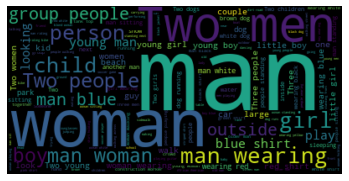

In [ ]:
# Print word cloud for visulization of most common words in say first 10000 sentences

# Start with one review
text = ''
for index in range(0,10000):
    text = text + df.sentences[index]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear',aspect=1)
plt.axis("off")
plt.show()

# Testing Network Architectures

Now that the dataset has been cleaned and preprocessed, we move ahead with testing various combinations of RNN models. Including Simple RNN's, LSTM, Bidirectional LSTM, GRU, Bidirectional GRU, Convolution 1D and maxpooling 1D for example.

Note: 
* Models 1 to 19 were trained using only dataset 2, because of translation issues with dataset 1. The google translate API used would sometimes not translate certain sentences. And because of a number of reasons including that a good portion of the dataset had to be translated, the translations were incomplete in some cases, and that the size of dataset one was very small compared to dataset 2; it was decided to go with dataset 2 for majority of the models.
* Model 20 was trained for a combined dataset (dataset 1 + dataset 2)
* Model 21 was trained with only the multilingual dataset (dataset 1)
* Model 22 is the final model. This model was trained on dataset 2 only.

A comparision of all the models can be found in the final model section.

#### Model 1 (Simple NN)


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          640000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_____________

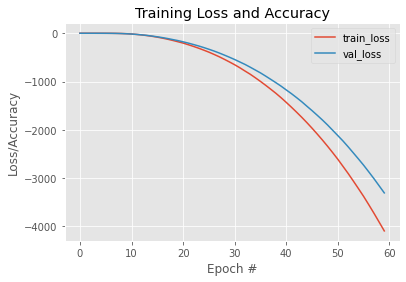

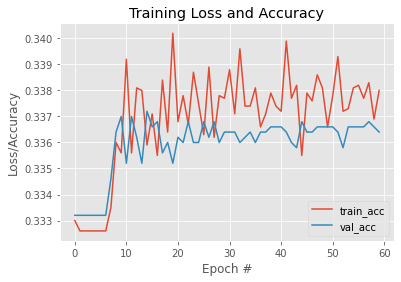

In [ ]:
# Training simple NN with embedding amd gloabl average pooling.

# Parameters
vocab_size = 5000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#### Model 2 (With a bidirectional LSTM)


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
___________

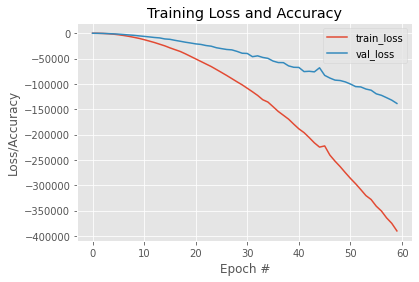

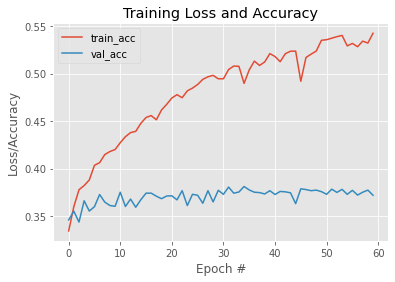

In [ ]:
# Training model with a single bidirectional LSTM layer followed by dense layers

# Parameters
vocab_size = 5000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#### Model 3 (With two bidirectional LSTM layers)


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 128)          640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
___________

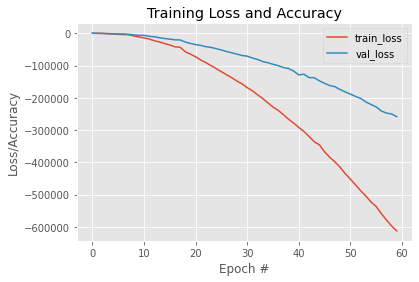

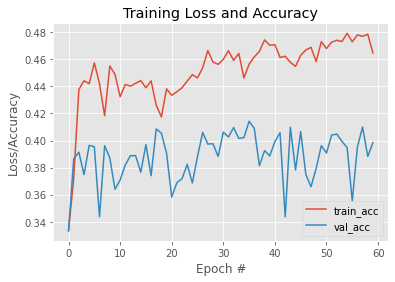

In [ ]:
# Training model with two consecutive bidirectional LSTM layer followed by dense layers

# Parameters
vocab_size = 5000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_____________

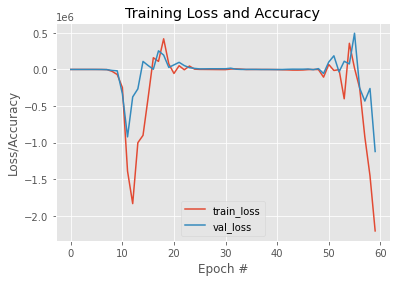

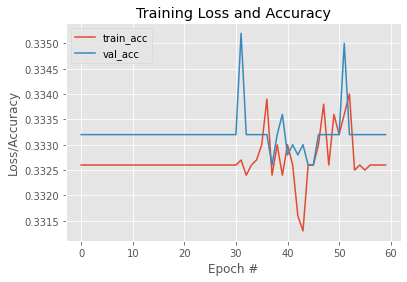

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Parameters
vocab_size = 5000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000
epochs = 60
initialLearningRate = 0.1
models = 4
# code for a learning rate scheduler
def shiftedCosineLearning(epoch):
    maxEpochs = epochs
    baseLearningRate = initialLearningRate

    alpha = (initialLearningRate/2)*(np.cos(np.pi*np.mod(epoch - 1, np.ceil(epochs/models))/np.ceil(epochs/models)) + 1)
    
    # return the learning rate
    return alpha

callbacks = [LearningRateScheduler(shiftedCosineLearning)]

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer=SGD(lr=initialLearningRate),metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, callbacks = callbacks,validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          640000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_____________

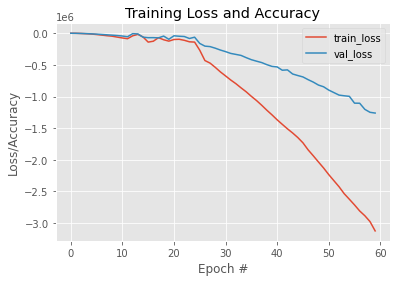

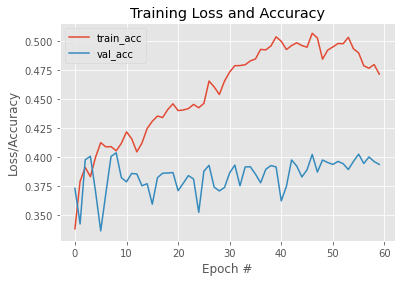

In [ ]:
# Parameters
vocab_size = 5000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_____________

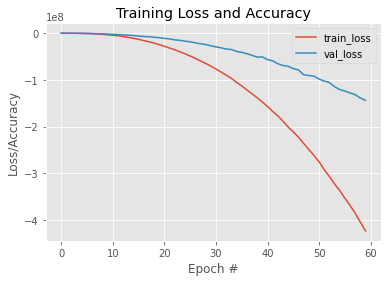

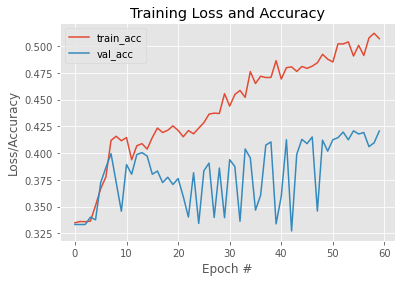

In [ ]:
# Parameters
vocab_size = 5000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_____________

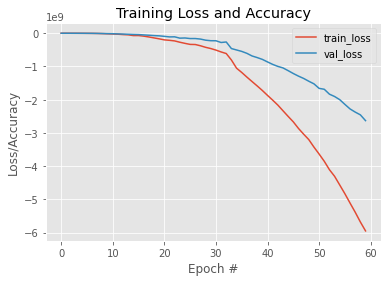

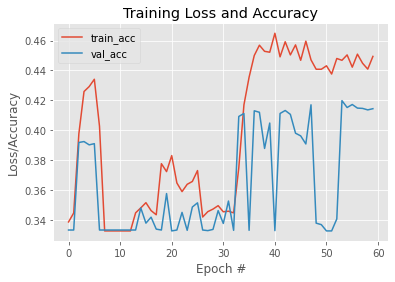

In [ ]:
# Parameters
vocab_size = 5000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#### Model 4 (With two bidirectional GRU layers)


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 128)          640000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          74496     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               74496     
___________

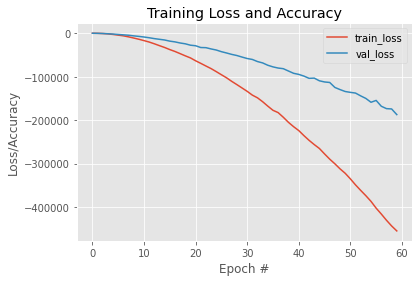

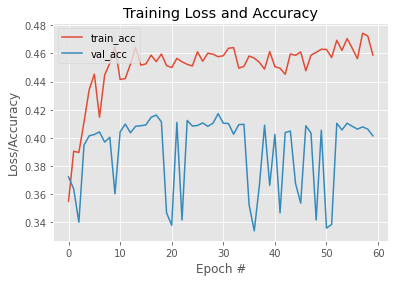

In [ ]:
# Training model with two consecutive bidirectional GRU layer followed by dense layers

# Parameters
vocab_size = 5000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          74496     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_____________

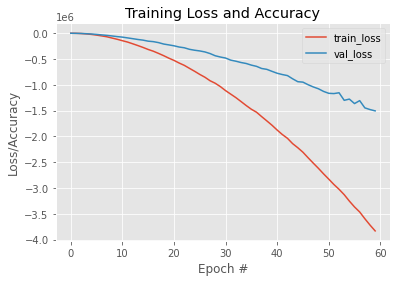

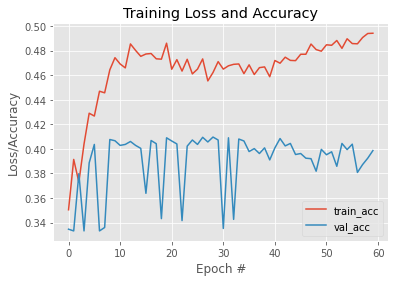

In [ ]:
# Parameters
vocab_size = 5000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#### Model 5 (With *three* GRU birectional layers)


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 512)          2560000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 512)          1182720   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 256)          493056    
___________

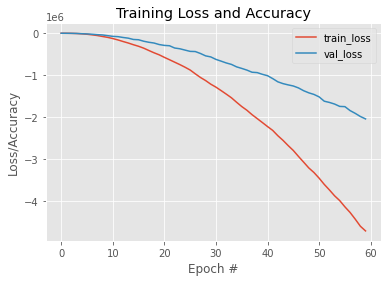

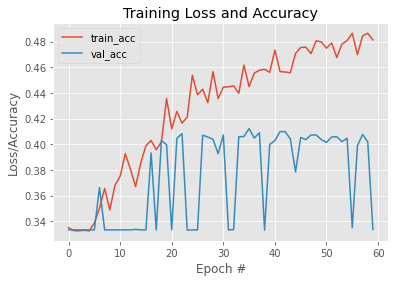

In [ ]:
# Training model with three consecutive bidirectional GRU layer followed by dense layers

# Parameters
vocab_size = 5000
# embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
embedding_dim = 512

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#### Model 6 (Single GRU layer)


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 512)          2560000   
_________________________________________________________________
gru_5 (GRU)                  (None, 256)               591360    
_________________________________________________________________
dense_10 (Dense)             (None, 500)               128500    
___________

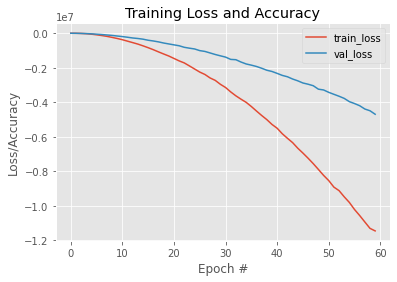

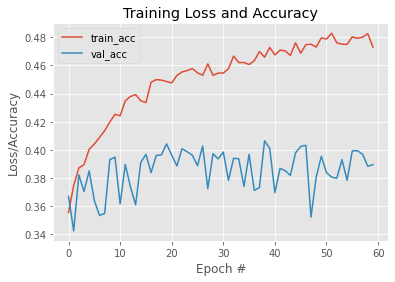

In [ ]:
# Training model with single GRU layer followed by dense layers

# Parameters
vocab_size = 5000
# embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
embedding_dim = 512

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(256),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#### Model 7 (With Single LSTM layer)


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 512)          2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 256)          787456    
_________________________________________________________________
dense (Dense)                (None, 100, 500)          128500    
_____________

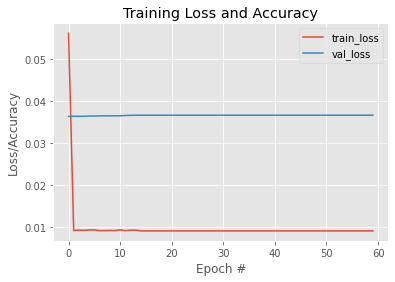

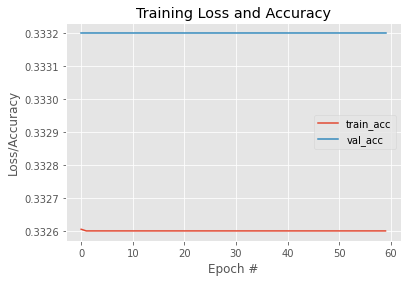

In [ ]:
# Training model a single LSTM layer followed by dense layers

# Parameters
vocab_size = 5000
# embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
embedding_dim = 512

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#### Model 8 (Single convolution)


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 512)          2560000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 64)           655424    
_________________________________________________________________
dense (Dense)                (None, 100, 500)          32500     
_____________

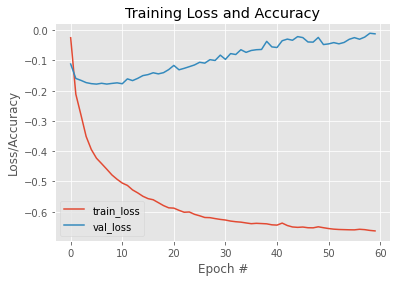

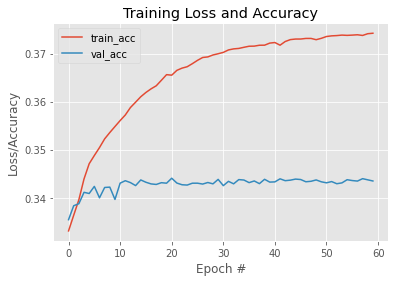

In [ ]:
# Training model with a single convolution layer followed by dense layers

# Parameters
vocab_size = 5000
# embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000
filterSize = 20

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
embedding_dim = 512

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(64, filterSize, padding ='same', activation = 'relu'),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#### Model 9 (Simple RNN)


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          640000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 500)               32500     
_____________

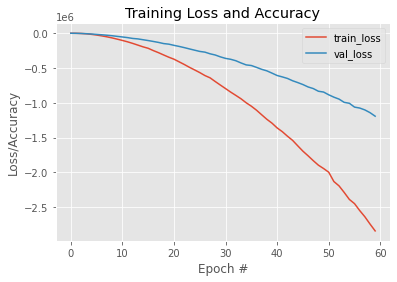

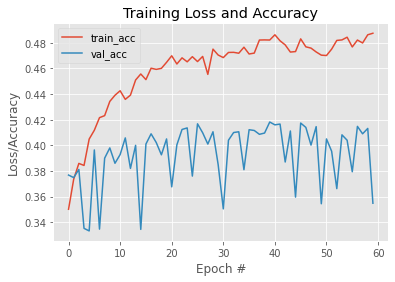

In [ ]:
# Training model with a SimpleRNN layer followed by dense layers

# Parameters
vocab_size = 5000
# embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
embedding_dim = 128

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#### Model 10 (birectional SimpleRNN)

In [ ]:
# Training model with bidirectional SimpleRNN layer followed by dense layers

# Parameters
vocab_size = 5000
# embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
embedding_dim = 512

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 512)          2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               73856     
_________________________________________________________________
dense (Dense)                (None, 500)               64500     
_____________

KeyboardInterrupt: ignored

#### MiniVGGNet

In [ ]:
# Clear Background GPU sessions
tf.keras.backend.clear_session()

class MiniVGGNet:
    def build(classes):
        model = Sequential(name = 'MiniVGGNet')

        model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))

        model.add(Conv1D(32, 20, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv1D(32, 20, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling1D(pool_size = 2, strides = 2))
        model.add(Dropout(0.25))
        
        model.add(Conv1D(32, 20, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv1D(32, 20, padding = 'same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling1D(pool_size = 2, strides = 2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "MiniVGGNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 32)           81952     
_________________________________________________________________
activation (Activation)      (None, 100, 32)           0         
_____________

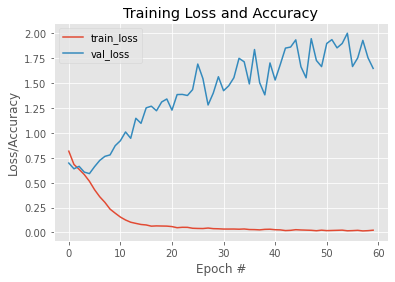

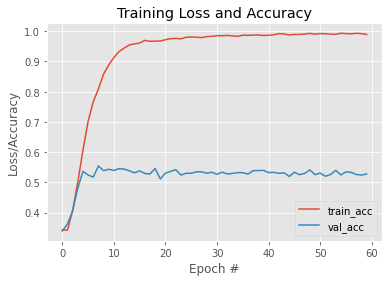

In [ ]:
from tensorflow.keras.models import Sequential
from keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization

# Training model with MiniVGG Net architecture modified for 1D convolutions

# Parameters
vocab_size = 5000
# embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
embedding_dim = 128

model = MiniVGGNet.build(3)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, to_categorical(df.label.to_numpy()[0:10000], 3), epochs=num_epochs, validation_data=(test_padded, to_categorical(df.label.to_numpy()[10000:15000],3)), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

#### Model 11 (bidirectional LSTM, SimpleRNN)


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          640000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          98816     
___________

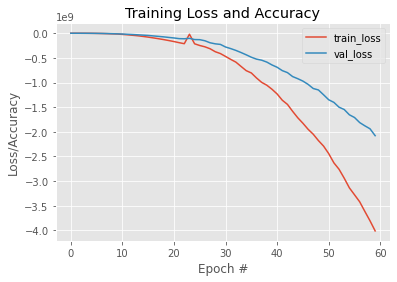

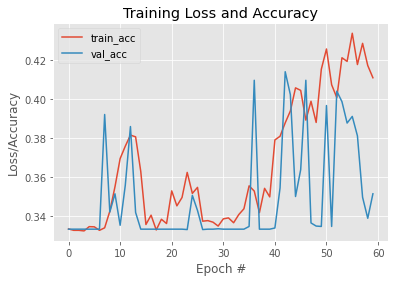

In [ ]:
# Training model with two bidirectional LSTM layers followed by SimlpeRNN followed by dense layers

# Parameters
vocab_size = 5000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [ ]:
# Parameters
vocab_size = 5000
embedding_dim = 128
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 10000

# Tokenize
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences[0:10000])
word_index = tokenizer.word_index

# Preparing train and test sequences and padding
train_sequences = tokenizer.texts_to_sequences(sentences[0:10000])
test_seq = tokenizer.texts_to_sequences(df.sentences.to_numpy().astype(str)[10000:15000])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_seq, maxlen=max_length)
print("\nPadded Train Sequence: ")
print(train_padded)
print("\nPadded Test Sequence: ")
print(test_padded)

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model and view summary
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Clear Background GPU sessions
tf.keras.backend.clear_session()

# Train the network
num_epochs = 60
history = model.fit(train_padded, df.label.to_numpy()[0:10000], epochs=num_epochs, validation_data=(test_padded, df.label.to_numpy()[10000:15000]), verbose=2)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, num_epochs), history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, num_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, num_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


Padded Train Sequence: 
[[   0    0    0 ...   35    2  411]
 [   0    0    0 ... 1764   17 4075]
 [   0    0    0 ...    7    2  198]
 ...
 [   0    0    0 ...   38 1376  153]
 [   0    0    0 ...    5    2   28]
 [   0    0    0 ...    4    3 1462]]

Padded Test Sequence: 
[[   0    0    0 ...    7    3  946]
 [   0    0    0 ...   80    3  271]
 [   0    0    0 ...  882  526 1436]
 ...
 [   0    0    0 ...  160    3  271]
 [   0    0    0 ...   29 1930  194]
 [   0    0    0 ...  160    3  105]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          24704     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               24704     
_____________

#### Model 12 - Double LSTM & Tokenization

Switching our approach a little, we try tokenizing over the entire dataset instead of just the train set.

In [ ]:
# Tokenize the dataset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train["sentence"].values)
tokenizer.num_words = 5000

In [ ]:
X = tokenizer.texts_to_sequences(df_train['sentence'].values)
X = pad_sequences(X)

In [ ]:
len(tokenizer.word_counts)

33260

In [ ]:
# Printing frequency of each tokenized word
tokenizer.word_counts

OrderedDict([('a', 1439098),
             ('person', 36014),
             ('on', 235910),
             ('horse', 7326),
             ('jumps', 6630),
             ('over', 17053),
             ('broken', 742),
             ('down', 39322),
             ('airplane', 1224),
             ('sep', 549361),
             ('is', 373352),
             ('training', 740),
             ('his', 72467),
             ('for', 42228),
             ('competition', 2590),
             ('at', 98662),
             ('diner', 253),
             ('ordering', 259),
             ('an', 80212),
             ('omelette', 2),
             ('outdoors', 9106),
             ('children', 26542),
             ('smiling', 8633),
             ('and', 206376),
             ('waving', 1372),
             ('camera', 11583),
             ('they', 10309),
             ('are', 199024),
             ('their', 27898),
             ('parents', 1024),
             ('there', 30940),
             ('present', 851),
             ('the

In [ ]:
# Create model with two LSTM's and dropout
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 115, 256)          1280000   
_________________________________________________________________
dropout (Dropout)            (None, 115, 256)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 115, 256)          525312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y = pd.get_dummies(df_train['label']).values
[print(df_train['label'][i], y[i]) for i in range(0,5)]

1 [0 1 0]
2 [0 0 1]
0 [1 0 0]
1 [0 1 0]
0 [1 0 0]


[None, None, None, None, None]

In [ ]:
type(X_train)

pandas.core.series.Series

In [ ]:
# Split dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Train the model

batch_size = 32
epochs = 10

H = model.fit(X_train[:1000], y_train[:1000], epochs=epochs, validation_data= (X_test[:500],y_test[:500]), batch_size=batch_size, verbose=2)

Epoch 1/10
32/32 - 28s - loss: 1.0951 - accuracy: 0.3420 - val_loss: 1.1287 - val_accuracy: 0.3400
Epoch 2/10
32/32 - 28s - loss: 1.0397 - accuracy: 0.4590 - val_loss: 1.0705 - val_accuracy: 0.4460
Epoch 3/10
32/32 - 28s - loss: 0.8315 - accuracy: 0.6410 - val_loss: 1.2247 - val_accuracy: 0.4100
Epoch 4/10
32/32 - 28s - loss: 0.5822 - accuracy: 0.7680 - val_loss: 1.3771 - val_accuracy: 0.4260
Epoch 5/10
32/32 - 28s - loss: 0.3639 - accuracy: 0.8630 - val_loss: 1.4870 - val_accuracy: 0.4400
Epoch 6/10
32/32 - 28s - loss: 0.1970 - accuracy: 0.9440 - val_loss: 2.2091 - val_accuracy: 0.4280
Epoch 7/10
32/32 - 28s - loss: 0.1363 - accuracy: 0.9510 - val_loss: 2.0774 - val_accuracy: 0.4160
Epoch 8/10
32/32 - 28s - loss: 0.0810 - accuracy: 0.9760 - val_loss: 2.3512 - val_accuracy: 0.4280
Epoch 9/10
32/32 - 27s - loss: 0.0665 - accuracy: 0.9770 - val_loss: 2.3939 - val_accuracy: 0.4200
Epoch 10/10
32/32 - 28s - loss: 0.0555 - accuracy: 0.9820 - val_loss: 2.2981 - val_accuracy: 0.4260


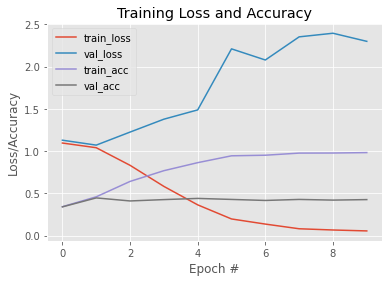

In [ ]:
# Print plots

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [ ]:
print(tokenizer.word_index)
total_words = len(tokenizer.word_index) + 1
print(total_words)

{'a': 1, 'sep': 2, 'the': 3, 'in': 4, 'is': 5, 'man': 6, 'on': 7, 'and': 8, 'are': 9, 'of': 10, 'with': 11, 'woman': 12, 'two': 13, 'to': 14, 'people': 15, 'at': 16, 'an': 17, 'wearing': 18, 'his': 19, 'shirt': 20, 'young': 21, 'men': 22, 'playing': 23, 'girl': 24, 'boy': 25, 'white': 26, 'while': 27, 'black': 28, 'dog': 29, 'sitting': 30, 'blue': 31, 'standing': 32, 'her': 33, 'for': 34, 'red': 35, 'group': 36, 'down': 37, 'walking': 38, 'outside': 39, 'street': 40, 'person': 41, 'front': 42, 'women': 43, 'holding': 44, 'by': 45, 'child': 46, 'one': 47, 'there': 48, 'three': 49, 'water': 50, 'their': 51, 'up': 52, 'looking': 53, 'children': 54, 'as': 55, 'some': 56, 'from': 57, 'green': 58, 'little': 59, 'other': 60, 'has': 61, 'large': 62, 'through': 63, 'running': 64, 'yellow': 65, 'out': 66, 'riding': 67, 'ball': 68, 'brown': 69, 'hat': 70, 'into': 71, 'next': 72, 'building': 73, 'near': 74, 's': 75, 'beach': 76, 'it': 77, 'over': 78, 'that': 79, 'dressed': 80, 'small': 81, 'girls'

####Model 13 - Triple LSTM & Tokenization

In [ ]:
# Train model with LSTM layers followed by droupout

model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, return_sequences = True, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

batch_size = 32
epochs = 10

# Train model
H = model.fit(X_train[:1000], y_train[:1000], epochs=epochs, batch_size=batch_size, verbose=2, validation_data= (X_test[:500],y_test[:500]))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 115, 256)          1280000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 115, 256)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 115, 256)          525312    
_________________________________________________________________
lstm_6 (LSTM)                (None, 115, 256)          525312    
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 2,856,707
Trainable params: 2,856,707
Non-trainable params: 0
____________________________________________

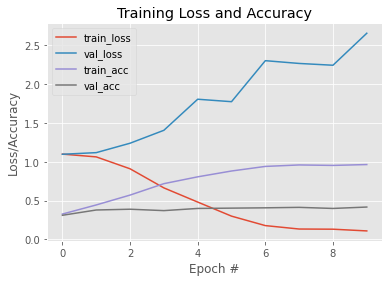

In [ ]:
# Print plots

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [ ]:
# Train model with LSTM layers followed by droupout

model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, return_sequences = True, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

batch_size = 32
epochs = 10

# Train model
H = model.fit(X_train[:1000], y_train[:1000], epochs=epochs, batch_size=batch_size, verbose=2 ,validation_data=(X_test[:100],y_test[:100]))


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 203, 256)          1280000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 203, 256)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 203, 256)          525312    
_________________________________________________________________
lstm_14 (LSTM)               (None, 203, 256)          525312    
_________________________________________________________________
lstm_15 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 771       
Total params: 2,856,707
Trainable params: 2,856,707
Non-trainable params: 0
____________________________________________

In [ ]:
X_train

array([[   0,    0,    0, ...,   27,  113,  550],
       [   0,    0,    0, ...,    7,    1,  511],
       [   0,    0,    0, ...,   14, 2957,    1],
       ...,
       [   0,    0,    0, ...,  841,    1,  832],
       [   0,    0,    0, ...,   11,   51, 1321],
       [   0,    0,    0, ...,  283,   34,  740]], dtype=int32)

#### Model 14 - Simple Bert




In [ ]:
df_train = pd.read_csv(DATA_DIR_2 + "train_data2.csv")

In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

import tensorflow_hub as hub

# Imports for bert
from keras.utils import np_utils
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert
from sklearn.preprocessing import LabelEncoder

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

     |████████████████████████████████| 849kB 8.0MB/s 
     |████████████████████████████████| 358kB 22.3MB/s 
     |████████████████████████████████| 36.7MB 87kB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
     |████████████████████████████████| 1.1MB 48.7MB/s 
     |████████████████████████████████| 174kB 55.1MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20071 sha256=235e72aec72710c931d5a4cb7f63f07dbcebbd7b7f8b2d64f542717c3d6ec623
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built py-cpuinfo
1 Physical GPUs, 1 Logical GPUs
Version:  2.3.0
Eager mode:  True
Hub version:  0.10.0
GPU is available


In [ ]:
# prepare sentences from premise-hypothesis pairs

sentence = []
for x in range(len(df_train["premise"])):
    s= str(df_train["premise"][x]) + str(df_train["hypothesis"][x])
    sentence.append(s)

In [ ]:
df_train.insert(0,'sentence',sentence)

In [ ]:
df_train.head()

sentence  ... label
0  A person on a horse jumps over a broken down a...  ...     1
1  A person on a horse jumps over a broken down a...  ...     2
2  A person on a horse jumps over a broken down a...  ...     0
3  Children smiling and waving at cameraThey are ...  ...     1
4  Children smiling and waving at cameraThere are...  ...     0

[5 rows x 4 columns]

In [ ]:
# Extract values and split into train and test set

x = df_train[:1000].sentence.values
y = df_train[:1000].label.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

In [ ]:
# Perform encoding

encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [ ]:
encoder_fname = 'nli_bert.npy'
my_wd = DATA_DIR_1
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)


INFO:absl:resolver HttpCompressedFileResolver does not support the provided handle.
INFO:absl:resolver GcsCompressedFileResolver does not support the provided handle.


In [ ]:
# Toknize

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
do_lower_case

False

In [ ]:
# Tokenizer id's
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would be much more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

sentences = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
x_train[0]

'A blond woman with two children is checking out at a Walmart register.A mother is with her two children at Walmart buying food'

In [ ]:
print('Tokenized Sentences shape', sentences.shape.as_list())

Tokenized Sentences shape [800, None]


In [ ]:
# Tokenize a single sentence
s = tokenizer.tokenize(x_train[0])
for i in s:
  print(i, tokenizer.convert_tokens_to_ids([i]))

A [138]
bl [21484]
##ond [26029]
woman [18299]
with [10169]
two [10551]
children [12694]
is [10124]
check [43662]
##ing [10230]
out [10950]
at [10160]
a [169]
W [160]
##al [10415]
##mar [14678]
##t [10123]
register [47424]
. [119]
A [138]
mother [15293]
is [10124]
with [10169]
her [10485]
two [10551]
children [12694]
at [10160]
W [160]
##al [10415]
##mar [14678]
##t [10123]
buy [47715]
##ing [10230]
food [18301]


In [ ]:
max_seq_length = 100
print('Max length is:', max_seq_length)

Max length is: 100


In [ ]:
# Prepare bert encoding functions

def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
# Encode train and test sets

X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [ ]:
num_class = len(encoder.classes_)
num_class

3

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

# Create model
model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

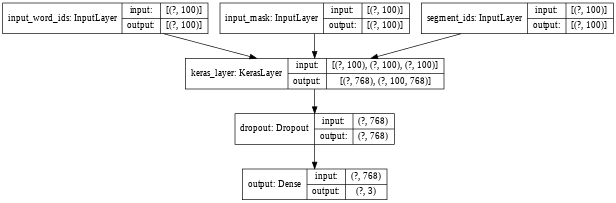

In [ ]:
# Plot model architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
# Set parameters for training
epochs = 3
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

INFO:absl:using Adamw optimizer


In [ ]:
# Compile model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
# Train model
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
50/50 [==============================] - 22s 438ms/step - loss: 1.1202 - accuracy: 0.3375 - val_loss: 1.1091 - val_accuracy: 0.3500
Epoch 2/3
50/50 [==============================] - 22s 437ms/step - loss: 1.0544 - accuracy: 0.4187 - val_loss: 1.0415 - val_accuracy: 0.4450
Epoch 3/3
50/50 [==============================] - 22s 448ms/step - loss: 0.9249 - accuracy: 0.5275 - val_loss: 0.9619 - val_accuracy: 0.4900


In [ ]:
# Print accuracies
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6725
Testing Accuracy:  0.4900


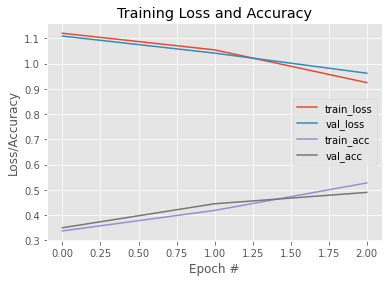

In [ ]:
# Print plots

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

####Model 15 -  Bert (More  Epochs)

In [ ]:
sentence = []
for x in range(len(df_train)):
    s = str(df_train["premise"][x])  + str(df_train["hypothesis"][x]) 
    #print(s)
    sentence.append(s)
df_train.insert(0,"sentence",sentence)

In [ ]:
x = df_train[:10000].sentence.values
y = df_train[:10000].label.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [ ]:
encoder_fname = 'nli_bert2.npy'
my_wd = DATA_DIR_1
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. 
   return tokenizer.convert_tokens_to_ids(tokens)

sentences = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
x_train[0]

'Three men and a woman caught midair jumping into a pool at a party.A group of people jumping into a pool.'

In [ ]:
print('Tokenized Sentences shape', sentences.shape.as_list())

Tokenized Sentences shape [8000, None]


In [ ]:
s = tokenizer.tokenize(x_train[0])
for i in s:
  print(i, tokenizer.convert_tokens_to_ids([i]))

Three [15139]
men [10588]
and [10111]
a [169]
woman [18299]
caught [39797]
mida [24760]
##ir [10835]
jumping [99257]
into [10708]
a [169]
pool [34183]
at [10160]
a [169]
party [14039]
. [119]
A [138]
group [11795]
of [10108]
people [11426]
jumping [99257]
into [10708]
a [169]
pool [34183]
. [119]


In [ ]:
max_seq_length = 100
print('Max length is:', max_seq_length)

Max length is: 100


In [ ]:
# Encode train and test set
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [ ]:
num_class = len(encoder.classes_)
num_class

3

In [ ]:
DENSE_HIDDEN_UNITS = 512
LSTM_UNITS = 64
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

# Create model
model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

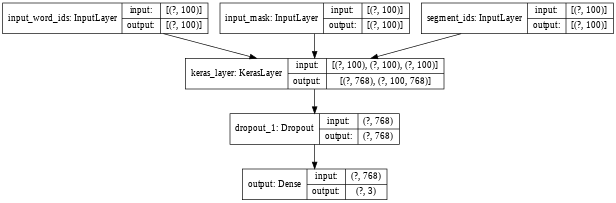

In [ ]:
# Print model architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
# Set model parameters
epochs = 10
batch_size = 32  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
# Compile model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
# Train model
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/10
250/250 [==============================] - 108s 433ms/step - loss: 0.8473 - accuracy: 0.6061 - val_loss: 0.6527 - val_accuracy: 0.7345
Epoch 2/10
250/250 [==============================] - 108s 431ms/step - loss: 0.5894 - accuracy: 0.7630 - val_loss: 0.6027 - val_accuracy: 0.7600
Epoch 3/10
250/250 [==============================] - 108s 431ms/step - loss: 0.4378 - accuracy: 0.8326 - val_loss: 0.6570 - val_accuracy: 0.7615
Epoch 4/10
250/250 [==============================] - 108s 431ms/step - loss: 0.3243 - accuracy: 0.8827 - val_loss: 0.7558 - val_accuracy: 0.7600
Epoch 5/10
250/250 [==============================] - 108s 431ms/step - loss: 0.2221 - accuracy: 0.9224 - val_loss: 0.8743 - val_accuracy: 0.7550
Epoch 6/10
250/250 [==============================] - 108s 431ms/step - loss: 0.1588 - accuracy: 0.9454 - val_loss: 0.9517 - val_accuracy: 0.7545
Epoch 7/10
250/250 [==============================] - 108s 432ms/step - loss: 0.1080 - accuracy: 0.9641 - val_loss: 1.0590 -

In [ ]:
# Print model performance
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9965
Testing Accuracy:  0.7560


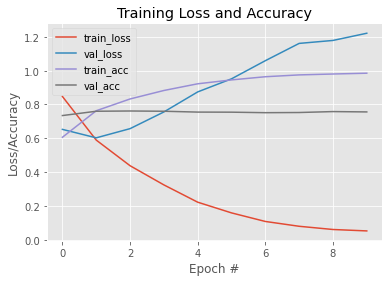

In [ ]:
# Print plots

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#### Model 16 -Droput(0.2)


In [ ]:

num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.2)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

# Create model
model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

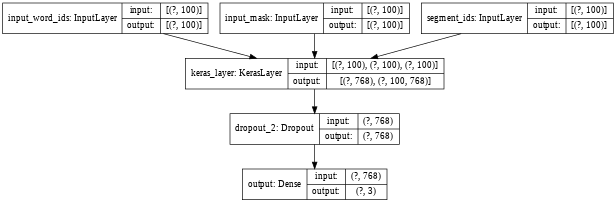

In [ ]:
# Print model architecture
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
# Set model parameters
epochs = 10
batch_size = 32  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
# Compile model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
# Train model
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/10
250/250 [==============================] - 108s 433ms/step - loss: 0.3456 - accuracy: 0.8484 - val_loss: 1.0380 - val_accuracy: 0.7430
Epoch 2/10
250/250 [==============================] - 108s 431ms/step - loss: 0.1511 - accuracy: 0.9480 - val_loss: 1.0863 - val_accuracy: 0.7595
Epoch 3/10
250/250 [==============================] - 108s 431ms/step - loss: 0.1039 - accuracy: 0.9655 - val_loss: 1.0166 - val_accuracy: 0.7610
Epoch 4/10
250/250 [==============================] - 108s 432ms/step - loss: 0.0771 - accuracy: 0.9734 - val_loss: 1.1053 - val_accuracy: 0.7580
Epoch 5/10
250/250 [==============================] - 108s 431ms/step - loss: 0.0562 - accuracy: 0.9815 - val_loss: 1.2474 - val_accuracy: 0.7555
Epoch 6/10
250/250 [==============================] - 108s 431ms/step - loss: 0.0346 - accuracy: 0.9877 - val_loss: 1.2873 - val_accuracy: 0.7585
Epoch 7/10
250/250 [==============================] - 108s 431ms/step - loss: 0.0323 - accuracy: 0.9895 - val_loss: 1.3664 -

Training Accuracy: 0.9999
Testing Accuracy:  0.7650


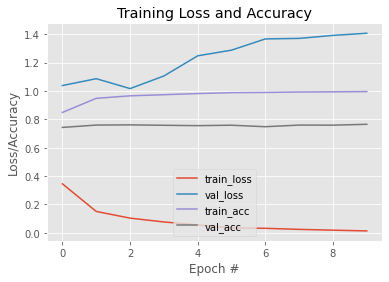

In [ ]:
# print accuracy and plots

loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#### Model 17 - Dropout(0.3)


In [ ]:

num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.3)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

# Create model
model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

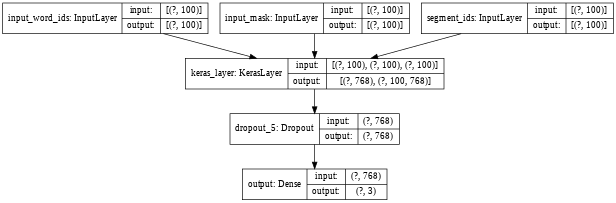

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
# Set model parameters
epochs = 10
batch_size = 32  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
# Compile model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]     

In [ ]:
# Train model
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/10
250/250 [==============================] - 108s 433ms/step - loss: 1.1282 - accuracy: 0.3392 - val_loss: 1.0986 - val_accuracy: 0.3345
Epoch 2/10
250/250 [==============================] - 108s 431ms/step - loss: 1.1129 - accuracy: 0.3369 - val_loss: 1.1001 - val_accuracy: 0.3305
Epoch 3/10
250/250 [==============================] - 108s 431ms/step - loss: 1.1173 - accuracy: 0.3257 - val_loss: 1.0988 - val_accuracy: 0.3345
Epoch 4/10
250/250 [==============================] - 108s 431ms/step - loss: 1.1137 - accuracy: 0.3358 - val_loss: 1.0988 - val_accuracy: 0.3305
Epoch 5/10
250/250 [==============================] - 108s 431ms/step - loss: 1.1134 - accuracy: 0.3257 - val_loss: 1.0987 - val_accuracy: 0.3345
Epoch 6/10
250/250 [==============================] - 108s 431ms/step - loss: 1.1100 - accuracy: 0.3246 - val_loss: 1.0986 - val_accuracy: 0.3345
Epoch 7/10
250/250 [==============================] - 108s 431ms/step - loss: 1.1101 - accuracy: 0.3395 - val_loss: 1.0987 -

Training Accuracy: 0.3341
Testing Accuracy:  0.3305


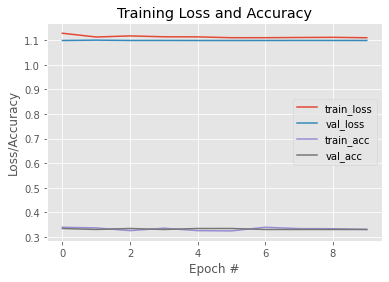

In [ ]:
# Print final accuaracies and plots

loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#### Model 18 - Loss


In [ ]:

num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.2)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

# Create model
model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

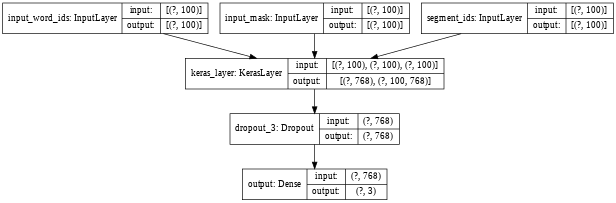

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
# Set model parameters

epochs = 10
batch_size = 32  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
# Compile model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
# Train model
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/10
250/250 [==============================] - 107s 429ms/step - loss: 0.1722 - accuracy: 0.8720 - val_loss: 0.6886 - val_accuracy: 0.7540
Epoch 2/10
250/250 [==============================] - 107s 427ms/step - loss: 0.0489 - accuracy: 0.9740 - val_loss: 0.8027 - val_accuracy: 0.7400
Epoch 3/10
250/250 [==============================] - 107s 427ms/step - loss: 0.0348 - accuracy: 0.9820 - val_loss: 0.8149 - val_accuracy: 0.7530
Epoch 4/10
250/250 [==============================] - 107s 427ms/step - loss: 0.0277 - accuracy: 0.9862 - val_loss: 0.8548 - val_accuracy: 0.7535
Epoch 5/10
250/250 [==============================] - 107s 427ms/step - loss: 0.0271 - accuracy: 0.9871 - val_loss: 0.8195 - val_accuracy: 0.7480
Epoch 6/10
250/250 [==============================] - 107s 427ms/step - loss: 0.0167 - accuracy: 0.9923 - val_loss: 0.8682 - val_accuracy: 0.7650
Epoch 7/10
250/250 [==============================] - 107s 427ms/step - loss: 0.0110 - accuracy: 0.9939 - val_loss: 0.9294 -

Training Accuracy: 1.0000
Testing Accuracy:  0.7640


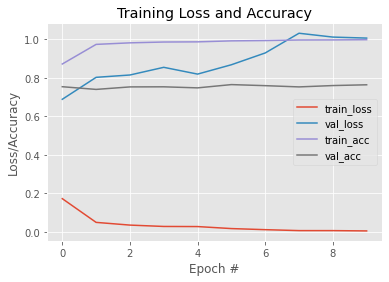

In [ ]:
# Print final accuracy
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# Print plots
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

####Model 19 - Optimizer


In [ ]:

num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.2)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

# Create model
model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

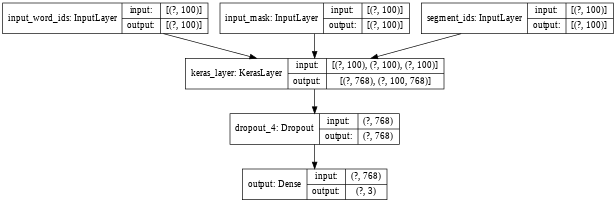

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:

# Set model parameters
epochs = 10
batch_size = 32  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = "RMSprop" 

In [ ]:
# Compile model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
# Train model
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/10
250/250 [==============================] - 104s 416ms/step - loss: 0.7752 - accuracy: 0.3332 - val_loss: 0.6924 - val_accuracy: 0.3345
Epoch 2/10
250/250 [==============================] - 103s 413ms/step - loss: 0.7509 - accuracy: 0.3196 - val_loss: 0.7249 - val_accuracy: 0.3305
Epoch 3/10
250/250 [==============================] - 103s 413ms/step - loss: 0.7323 - accuracy: 0.3365 - val_loss: 0.6391 - val_accuracy: 0.3305
Epoch 4/10
250/250 [==============================] - 103s 413ms/step - loss: 0.7222 - accuracy: 0.3325 - val_loss: 0.6425 - val_accuracy: 0.3345
Epoch 5/10
250/250 [==============================] - 103s 414ms/step - loss: 0.7139 - accuracy: 0.3276 - val_loss: 0.6469 - val_accuracy: 0.3305
Epoch 6/10
250/250 [==============================] - 103s 413ms/step - loss: 0.7040 - accuracy: 0.3354 - val_loss: 0.6556 - val_accuracy: 0.3350
Epoch 7/10
250/250 [==============================] - 103s 413ms/step - loss: 0.7015 - accuracy: 0.3313 - val_loss: 0.6617 -

Training Accuracy: 0.3338
Testing Accuracy:  0.3350


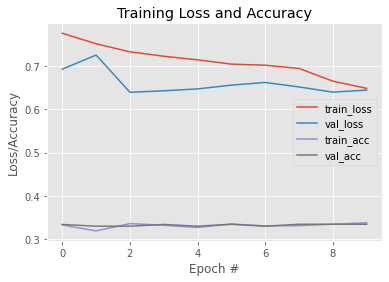

In [ ]:
# Print final accuracies
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# Print performance plots
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#### Model 20 :BERT (Combined data)

In [ ]:
# Load combined dataset (dataset_1 + dataset_2)
df_train = pd.read_csv(DATA_DIR_3 + "final_combined.csv")

In [ ]:
# Combine sentences

sentence = []

for x in range(len(df_train["premise"])):
    s= str(df_train["premise"][x]) + str(df_train["hypothesis"][x])
    sentence.append(s)

In [ ]:
df_train.insert(0,'sentence',sentence)

In [ ]:
df_train.head()

sentence  ... label
0  These are issues that we wrestle with in pract...  ...     2
1  Little things like these make a huge differenc...  ...     0
2  you know they can t really defend themselves l...  ...     0
3  In role playing as well Opportunities to expre...  ...     1
4  You might hear someone on a farm saying we sho...  ...     0

[5 rows x 4 columns]

In [ ]:
# Split train and test data
x = df_train[:10000].sentence.values
y = df_train[:10000].label.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [ ]:
encoder_fname = 'nli_bert.npy'
my_wd = DATA_DIR_1
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)


In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
do_lower_case

False

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
# Encoding function for a test
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

sentences = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
x_train[0]

'Yes, he offered to buy, well, this ... a mop like yours. He offered to find a mop. '

In [ ]:
print('Tokenized Sentences shape', sentences.shape.as_list())

Tokenized Sentences shape [800, None]


In [ ]:
s = tokenizer.tokenize(x_train[0])
for i in s:
  print(i, tokenizer.convert_tokens_to_ids([i]))

Yes [40690]
, [117]
he [10261]
offered [20841]
to [10114]
buy [47715]
, [117]
well [11206]
, [117]
this [10531]
. [119]
. [119]
. [119]
a [169]
mo [46912]
##p [10410]
like [11850]
your [20442]
##s [10107]
. [119]
He [10357]
offered [20841]
to [10114]
find [17860]
a [169]
mo [46912]
##p [10410]
. [119]


In [ ]:
max_seq_length = 100
print('Max length is:', max_seq_length)

Max length is: 100


In [ ]:
# Encoding functions as previously defined

def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
# Perform encoding for bert

X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [ ]:
num_class = len(encoder.classes_)
num_class

3

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.2)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

# Create model
model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

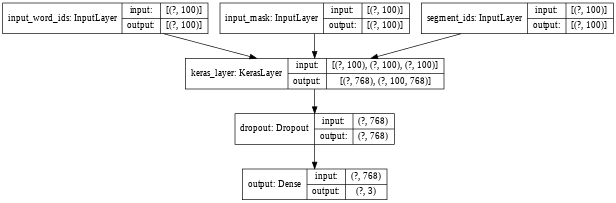

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)


In [ ]:
# Set model parameters

epochs = 10
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
# Compile model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
# Train model
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/10
50/50 [==============================] - 22s 448ms/step - loss: 0.0325 - accuracy: 0.9987 - val_loss: 2.1931 - val_accuracy: 0.4400
Epoch 2/10
50/50 [==============================] - 22s 443ms/step - loss: 0.0365 - accuracy: 0.9950 - val_loss: 2.1931 - val_accuracy: 0.4400
Epoch 3/10
50/50 [==============================] - 22s 435ms/step - loss: 0.0344 - accuracy: 0.9975 - val_loss: 2.1931 - val_accuracy: 0.4400
Epoch 4/10
50/50 [==============================] - 22s 437ms/step - loss: 0.0380 - accuracy: 0.9912 - val_loss: 2.1931 - val_accuracy: 0.4400
Epoch 5/10
50/50 [==============================] - 22s 441ms/step - loss: 0.0402 - accuracy: 0.9900 - val_loss: 2.1931 - val_accuracy: 0.4400
Epoch 6/10
50/50 [==============================] - 22s 442ms/step - loss: 0.0332 - accuracy: 0.9962 - val_loss: 2.1931 - val_accuracy: 0.4400
Epoch 7/10
50/50 [==============================] - 22s 439ms/step - loss: 0.0310 - accuracy: 0.9975 - val_loss: 2.1931 - val_accuracy: 0.4400

In [ ]:
# Print final train and test set accuracy
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9987
Testing Accuracy:  0.4400


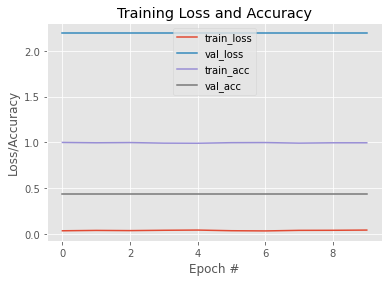

In [ ]:
# Print plots
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#### Model 21 BERT (Multilinguistic dataset 1)

In [ ]:
# Taking only processed dataset 1
df_train = pd.read_csv("/content/drive/MyDrive/Data/contradictory-my-dear-watson/ds1_processed.csv")

In [ ]:
# Combine sentences
sentence = []

for x in range(len(df_train["premise"])):
    s= str(df_train["premise"][x]) + str(df_train["hypothesis"][x])
    sentence.append(s)

In [ ]:
df_train.insert(0,'sentence',sentence)

In [ ]:
df_train.head()

sentence  ...  label
0  and these comments were considered in formulat...  ...      0
1  These are issues that we wrestle with in pract...  ...      2
2  Des petites choses comme celles là font une di...  ...      0
3  you know they can t really defend themselves l...  ...      0
4  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...  ...      1

[5 rows x 8 columns]

In [ ]:
# Train-test split

x = df_train[:10000].sentence.values
y = df_train[:10000].label.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [ ]:
encoder_fname = 'nli_bert.npy'
my_wd = DATA_DIR_1
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)


In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
do_lower_case

False

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
print('Tokenized Sentences shape', sentences.shape.as_list())

Tokenized Sentences shape [8000, None]


In [ ]:
s = tokenizer.tokenize(x_train[0])
for i in s:
  print(i, tokenizer.convert_tokens_to_ids([i]))

i [177]
think [27874]
it [10271]
s [187]
nine [19964]
##ty [11195]
two [10551]
##I [11281]
gu [75980]
##ess [22094]
it [10271]
is [10124]
nine [19964]
##ty [11195]
two [10551]
. [119]


In [ ]:
max_seq_length = 100
print('Max length is:', max_seq_length)

Max length is: 100


In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [ ]:
num_class = len(encoder.classes_)
num_class

3

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.2)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

# Create model
model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

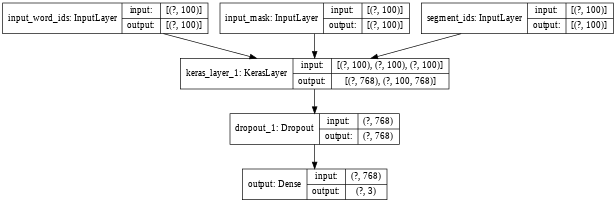

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)


In [ ]:
# Set model parameters
epochs = 10
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
# Compile model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
# Train model
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 1.0964 - accuracy: 0.3652WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0101s vs `on_test_batch_end` time: 0.1072s). Check your callbacks.


500/500 [==============================] - 223s 446ms/step - loss: 1.0964 - accuracy: 0.3652 - val_loss: 0.9740 - val_accuracy: 0.5475
Epoch 2/10
500/500 [==============================] - 222s 444ms/step - loss: 0.9094 - accuracy: 0.5799 - val_loss: 0.8620 - val_accuracy: 0.5950
Epoch 3/10
500/500 [==============================] - 222s 443ms/step - loss: 0.6833 - accuracy: 0.7081 - val_loss: 0.9740 - val_accuracy: 0.6055
Epoch 4/10
500/500 [==============================] - 222s 444ms/step - loss: 0.4206 - accuracy: 0.8300 - val_loss: 1.1380 - val_accuracy: 0.6115
Epoch 5/10
500/500 [==============================] - 222s 443ms/step - loss: 0.2410 - accuracy: 0.9107 - val_loss: 1.3608 - val_accuracy: 0.6075
Epoch 6/10
500/500 [==============================] - 222s 444ms/step - loss: 0.1467 - accuracy: 0.9470 - val_loss: 1.4955 - val_accuracy: 0.6085
Epoch 7/10
500/500 [==============================] - 222s 444ms/step - loss: 0.0824 - accuracy: 0.9709 - val_loss: 1.8494 - val_accura

In [ ]:
# Print final model accuracy
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

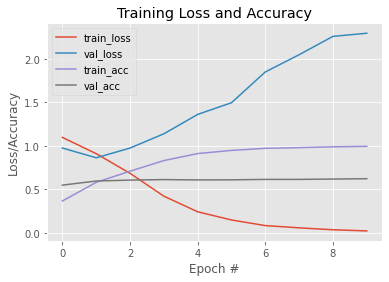

In [ ]:
# Print plots

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#### Model 22  Final Model


Based on the above created models; a comparison was made and final model was selected.


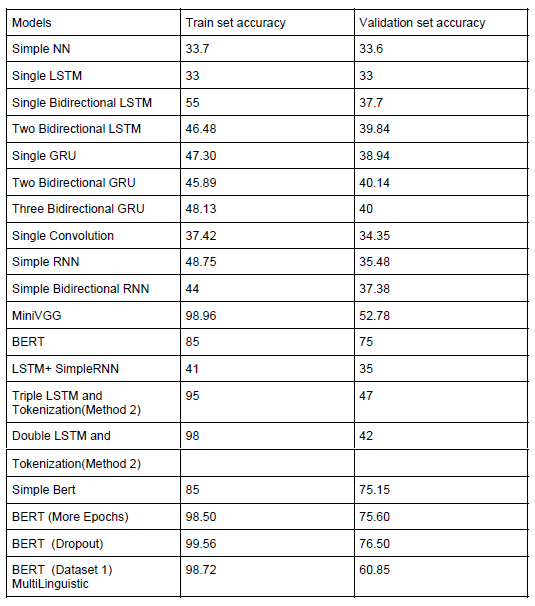

In [3]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

     |████████████████████████████████| 849kB 8.8MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 36.7MB 87kB/s 
     |████████████████████████████████| 1.1MB 54.0MB/s 
     |████████████████████████████████| 174kB 61.5MB/s 
     |████████████████████████████████| 358kB 56.8MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20072 sha256=8691da595c113cd0331f2bed01a67fafd964f58a219afb44d2bef390f0df8813
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built py-cpuinfo


In [10]:
import tensorflow_hub as hub

# Imports for bert
from keras.utils import np_utils
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert
from sklearn.preprocessing import LabelEncoder

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.4.0
Eager mode:  True
Hub version:  0.10.0
GPU is available


In [4]:
# Load dataset 2
df_train = pd.read_csv(DATA_DIR_2 + "train_data2.csv")

In [5]:
# Cobine sentences
sentence = []
for x in range(len(df_train)):
    s = str(df_train["premise"][x])  + str(df_train["hypothesis"][x]) 
    #print(s)
    sentence.append(s)
df_train.insert(0,"sentence",sentence)

In [7]:
# Train-test split

from sklearn.model_selection import train_test_split
x = df_train[:100000].sentence.values
y = df_train[:100000].label.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [11]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [13]:
import os
encoder_fname = 'nli_bert3.npy'
my_wd = DATA_DIR_1
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

In [14]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)


In [15]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [16]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [17]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. 
   return tokenizer.convert_tokens_to_ids(tokens)

sentences = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [18]:
x_train[0]

'A doctor looking at his paperwork in a patient s room.The female is sipping beer on the top of a mountain.'

In [19]:
print('Tokenized Sentences shape', sentences.shape.as_list())

Tokenized Sentences shape [80000, None]


In [20]:
s = tokenizer.tokenize(x_train[0])
for i in s:
  print(i, tokenizer.convert_tokens_to_ids([i]))

A [138]
doctor [26937]
looking [34279]
at [10160]
his [10226]
paper [17895]
##work [37382]
in [10106]
a [169]
patient [38607]
s [187]
room [19555]
. [119]
The [10117]
female [16762]
is [10124]
si [10294]
##pping [53570]
beer [73768]
on [10135]
the [10105]
top [12364]
of [10108]
a [169]
mountain [25233]
. [119]


In [21]:
max_seq_length = 100
print('Max length is:', max_seq_length)

Max length is: 100


In [22]:
# Encoding functions

def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [23]:
# Encode sentences

X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [24]:
num_class = len(encoder.classes_)
num_class

3

In [25]:
DENSE_HIDDEN_UNITS = 512
LSTM_UNITS = 64
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.2)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

# Create model
model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

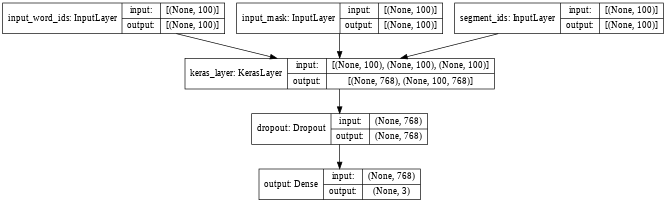

In [26]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)


In [27]:
# Set model parameters
epochs = 10
batch_size = 32  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [28]:
# Compile model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [30]:
# Train model
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/10
2500/2500 [==============================] - 2047s 813ms/step - loss: 0.9012 - accuracy: 0.5414 - val_loss: 0.5506 - val_accuracy: 0.7771
Epoch 2/10
2500/2500 [==============================] - 2034s 814ms/step - loss: 0.4953 - accuracy: 0.8055 - val_loss: 0.4633 - val_accuracy: 0.8241
Epoch 3/10
2500/2500 [==============================] - 2034s 813ms/step - loss: 0.3643 - accuracy: 0.8657 - val_loss: 0.4434 - val_accuracy: 0.8336
Epoch 4/10
2500/2500 [==============================] - 2034s 814ms/step - loss: 0.2731 - accuracy: 0.9026 - val_loss: 0.5099 - val_accuracy: 0.8324
Epoch 5/10
2500/2500 [==============================] - 2035s 814ms/step - loss: 0.2134 - accuracy: 0.9264 - val_loss: 0.5394 - val_accuracy: 0.8326
Epoch 6/10
2500/2500 [==============================] - 2036s 814ms/step - loss: 0.1649 - accuracy: 0.9459 - val_loss: 0.6430 - val_accuracy: 0.8324
Epoch 7/10
2500/2500 [==============================] - 2037s 815ms/step - loss: 0.1320 - accuracy: 0.9585

In [31]:
# Print final model accuracy
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9934
Testing Accuracy:  0.8323


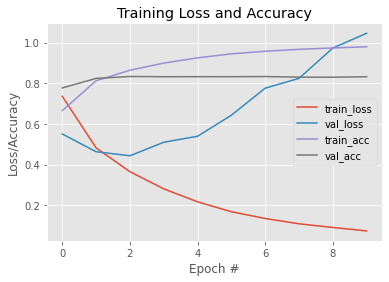

In [32]:
# Print plots

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), history.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label = 'train_acc')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

In [33]:
# Saving model and model weights
model.save_weights(DATA_DIR_2 + 'final_model_weights')
model.save(DATA_DIR_2 + 'final_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks (1)/Data/Data/stanford-natural-language-inference-corpus/final_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks (1)/Data/Data/stanford-natural-language-inference-corpus/final_model/assets


Final model classification accuracies;

|Train Set|Test Set|
|---|---|
|99.34|83.33|